# Notebook for Modeling and Data Analysis - LD,75 Modeling Paper

This notebook is a version of earlier modeling efforts, used for a very specific dataset for a paper that will be submitted imminently to ACSEL? EES? Adv. Mater.? This will be considered the authoritative guide to which data will be considered for use in this effort.

In [1]:
# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt


#change default plot settings
'''default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)'''
mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:

# function to correlate variables, calculate Pearson r, and plot results
def pearson_correlation(x,y,x_lab,y_lab):
    plt.figure()
    plt.plot(x,y,'.')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    #infinites = np.logical_or(np.isfinite(x), np.isfinite(y))
    #invalids = np.logical_or(nas,infinites)
    z = scipy.stats.pearsonr(x[~nas],y[~nas])
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),1.2*np.max(y))
    plt.text(0.5*(np.min(x)+np.max(x)),1.1*np.max(y),np.round(z,decimals=3))
    #print(np.round(z,decimals=3))

def bleach_rate_from_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # if the loop gets to the end without crossing the threshold, assign NaN value to the bleaching rate
    if kk == len(Tr)-1:
        tau = np.nan
    else:
    # do linear interpolation between points just above and just below threshold to get 
    # "failure" time at exactly the threshold
        tau = t[kk-1] + (t[kk]-t[kk-1])*(threshold-Tr[kk-1])/(Tr[kk]-Tr[kk-1])
    
    # invert "failure time" to get bleaching rate, in 1/min
    bleach_rate = (threshold-1)/tau
    
    # return the bleaching rate
    return bleach_rate

# alternative way to extract bleaching rate: instead of taking secant approximation to degradation rate, 
# perform a linear fit to all the data up to the threshold and ignore everything else;
# if the threshold can't be reached, just fit the entire dataset
def bleach_rate_from_linear_fit_to_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # use linear polynomial fit up to threshold
    coeffs = np.polyfit(t[:kk+1],Tr_norm[:kk+1],1)
    bleach_rate = coeffs[0]
    intercept = coeffs[1]
    
    # return the bleaching rate
    return bleach_rate, intercept

# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
    if temp <= 15:
        m_color = np.array([0.00,0.00,0.20])
    elif 15 < temp <= 35:
        m_color = np.array([0.00,0.20,0.20])
    elif 35 < temp <= 55:
        m_color = np.array([0.00,0.20,0.00])
    elif 55 < temp <= 75:
        m_color = np.array([0.20,0.20,0.00])
    elif 75 < temp:
        m_color = np.array([0.20,0.00,0.00])

    # humidity encoded by brightness
    if rh < 10:
        m_color *= 1
    elif 10 < rh < 30:
        m_color *= 2
    elif 30 < rh < 50:
        m_color *= 3
    elif 50 < rh < 70:
        m_color *= 4
    elif 70 < rh:
        m_color *= 5

    # illumination encoded by marker shape
    if illum == 8:
        m_shape = 'o'
    elif illum == 32:
        m_shape = 'D'
    elif illum == 1:
        m_shape = 'v'
    elif illum == 16:
        m_shape = 's'
    elif illum == 0:
        m_shape = 'p'

    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 50:
        m_fill = 'right'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

def plot_residuals(resids):
    plt.figure()
    _, bins, _ = plt.hist(resids)
    resid_mean = np.mean(resids)
    resid_sd = np.std(resids)
    resid_x=np.linspace(np.min(resids),np.max(resids),num=100)
    norm_dist = np.exp(-0.5*((resid_x-resid_mean)/resid_sd)**2)/(resid_sd*np.sqrt(2*np.pi))
    scale = len(resids)*(bins[1]-bins[0])
    plt.plot(resid_x,norm_dist*scale)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')    
            
# interpolate early time features to a universal time range (default is 10 min)
def interp_early_time(time_raw,timeseries,univ_horiz=10):

    idx = np.abs(time_raw-univ_horiz).idxmin() # index of datapoint closest to the horizon
    # if the nth index is at or below the horizon, increment by one;
    # otherwise, leave as is so as not to include predictions outside
    if time_raw[idx] >= univ_horiz:
        idx += 1
    else:
        idx += 2
    # interpolate from range of allowed indices to prediction horizon (5 points after start)
    series_interp_func = sp.interpolate.interp1d(time_raw[:idx],timeseries[:idx])
    t = np.linspace(0,univ_horiz,num=6)
    series_interp = series_interp_func(t)

    return(series_interp[-5:])

In [2]:
# In this cell: load all the data

# Paths to directories containing data you wish to analyze

# Basic directory on Drive corresponding to where the post-pipeline timeseries data are stored
base_dir = 'G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/'

# Specify class ID
# BASE DIRECTORY FOR THE STUDY: 191203 Full Factorial Study on Unencapsulated Films
classID = '191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study'
#classID = '2020_1-22EncapsulationStudy'

############# FREQUENTLY NEEDS EDITING ##############
# Specify which experiments within a given class to analyze - in this case we are getting all of them
expt_list = glob.glob(base_dir + classID + '/' + 'PL_PC_T_*')

# Add auxiliary experiments from other classes if you wish - in this case grab all the MAPI experiments from the
# ACSEL paper study
test_class = '190916_PLVA_Perovskite_Degradation_Study'# auxiliary experiment IDs
aux_list = glob.glob(base_dir + test_class + '/' + 'PL_PC_T_MAP*')

# Also add MAPI reproducibility study run
repl_class = '200525_Replication_Study (1)'
repl_list = [base_dir + repl_class + '/' + 'PL_PC_T_MAPI_8Sun_25C_60RH_air_1_1',
             base_dir + repl_class + '/' + 'PL_PC_T_MAPI_8Sun_25C_60RH_air_1_2',
             base_dir + repl_class + '/' + 'PL_PC_T_MAPI_8Sun_25C_60RH_air_1_3',
             base_dir + repl_class + '/' + 'PL_PC_T_MAPI_8Sun_25C_60RH_air_2_1',
             base_dir + repl_class + '/' + 'PL_PC_T_MAPI_8Sun_25C_60RH_air_2_2',
             base_dir + repl_class + '/' + 'PL_PC_T_MAPI_8Sun_25C_60RH_air_2_3',]

# And add spring 2020 study on compositions - most of these will be filtered out
# by the temperature criterion
comp_class = '200520_Composition_Study'
comp_list = [base_dir + comp_class + '/' + 'PL_PC_T_FACs_1Sun_25C_40RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_FACs_32Sun_85C_20RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_FACs_32Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_FACs_32Sun_85C_60RH_O2',
             base_dir + comp_class + '/' + 'PL_PC_T_x500_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x063_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x094_1Sun_25C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x125_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x156_1Sun_25C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x25_8Sun_45C_60RH_O2',
             base_dir + comp_class + '/' + 'PL_PC_T_x031_1Sun_25C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x219_1Sun_25C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x188_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x100_8Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x281_1Sun_25C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x438_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x406_8Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x400_8Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x313_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x300_8Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x350_8Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x200_8Sun_85C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x800_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_MAPI_1Sun_25C_40RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x375_8Sun_45C_60RH_air',
             base_dir + comp_class + '/' + 'PL_PC_T_x900_8Sun_45C_60RH_air',
             ]

# concatenate lists of experiments
expt_list = expt_list + aux_list + repl_list + comp_list

#expt_list = repl_list

for expt in expt_list:
    print(expt)

G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_85C_60RH_21pctO2_Unencap
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap_3
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_85C_20RH_21pctO2_Unencap
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_32Sun_85C_60RH_21pctO2_Unencap
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8

G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap
['G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap/primary_vids\\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap_grad0_loc0_time0']
Experiment started at:
2019-12-03 14:05:13 -0800
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_85C_60RH_21pctO2_Unencap


<ipython-input-3-92edcad38709>:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LD[72:93] = np.nan
C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-3-92edcad38709>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LD[jj+1] = (LD_move_avg[jj]+LD_move_avg[jj])/2


['G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\\PL_PC_T_FAPIBr3_8Sun_85C_60RH_21pctO2_Unencap/primary_vids\\PL_PC_T_FAPIBr3_8Sun_85C_60RH_21pctO2_Unencap_grad0_loc0_time0']
Experiment started at:
2019-12-04 10:29:28 -0800
G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap_3


<ipython-input-3-92edcad38709>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LD[jj+1] = (LD_move_avg[jj]+LD_move_avg[jj])/2


KeyboardInterrupt: 

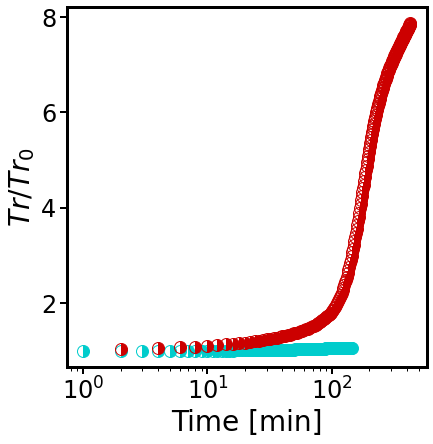

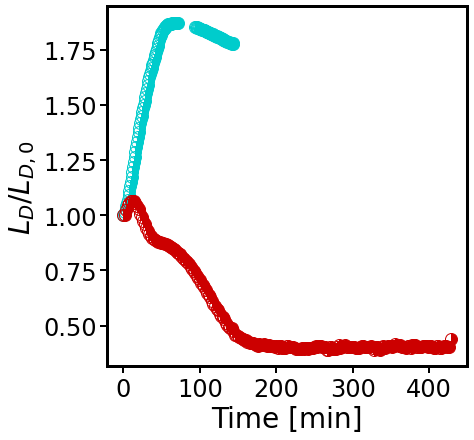

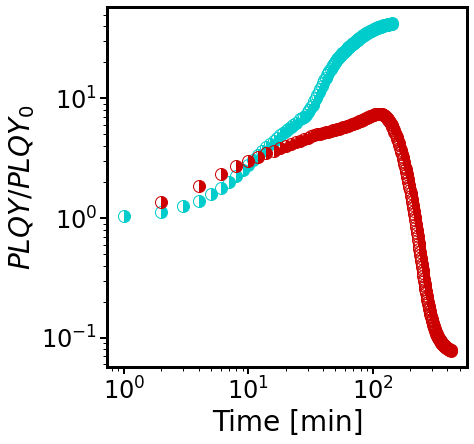

In [3]:


# initialize array for factorial analysis for later conversion to dataframe
raw_data = np.zeros([len(expt_list),67])

# how many points to use for early-time fitting
points_to_sample = 5

# initialize figure axes for plotting
Tr_fig = plt.figure(figsize=(10,10))
Tr_ax = Tr_fig.add_axes([0.25, 0.25, 0.5, 0.5])

LD_fig = plt.figure(figsize=(10,10))
LD_ax = LD_fig.add_axes([0.25, 0.25, 0.5, 0.5])

PL_fig = plt.figure(figsize=(10,10))
PL_ax = PL_fig.add_axes([0.25, 0.25, 0.5, 0.5])

ExptIDs = []
ClassIDs = []

for ii,prototype in enumerate(expt_list):
    
    # ERROR CHECKING: uncomment the line below if you have any doubts about whether the correct files are being loaded
    #print(prototype)
        
    # make the prototype the first entry in the list of chunks
    chunks = []
    chunks.append(prototype)

    # identify the directory corresponding to each additional chunk, and SORT THEM
    chunks += sorted(glob.glob(prototype + '_ctd*'))

    # after loading the prototype data, scan through each chunk in sequence
    for chunk in chunks:
        print(chunk)
        
        # By default, assume that the data collection was started fresh each chunk -
        # i.e. that it was started either because it was the first chunk, or the whole program timed out
        # and Python and MM had to be started together.
        MM_crash = False
        
        # Determine whether the chunk is the prototypical/first portion: certain tasks must be done on this 
        # iteration (such as getting early-time features) but cannot be done on others, while other tasks are
        # unnecessary to repeat (such as loading environment and composition)
        if chunk == prototype:
            
            ##################################
            # LOAD ENVIRONMENT AND COMPOSITION
            ##################################
            
            # first, if reading in the first run, grab the environment and sample metadata (only need to do this once)
            # extract experiment parameters from the metadata
            MDpath = chunk + '/primary_vids/Experiment Info/experiment_info.json'
            with open(MDpath) as json_file:
                metadata = json.load(json_file)
            T = metadata['Temperature (deg C)'] 
            RH = metadata['Atmosphere_RH (%)']
            pct_O2 = metadata['Atmosphere_O2 (%)']
            N_suns = metadata['Excitation Intensity']
            chan_l = metadata['channel_length']
            chan_w = metadata['channel_width']
            ClassIDs.append(metadata['ClassID'])
            ExptIDs.append(metadata['ExperimentID'])

            # read sample metadata file to get the composition 
            # (A-site only implemented for now, but should be straightforward to expand)
            SDpath = chunk + '/primary_vids/Sample Info/sample_info.json'
            with open(SDpath) as json_file:
                sampledata = json.load(json_file)
            # get A-site composition and parse into a dictionary of component fractions
            A_comp = sampledata['Starting Composition A-site'] 
            parse = A_comp.split(' ')
            n = len(parse)
            A_comp_dict = {}

            for jj in range(int(len(parse)/2)):
                A_comp_dict[parse[2*jj]] = parse[2*jj+1]

            try:
                MA_frac = A_comp_dict['MA']
            except:
                MA_frac = 0

            # try to get stress intensity, if different from probe/excitation intensity
            try:
                N_suns_stress = metadata['Stress Intensity']
            except:
                N_suns_stress = N_suns

            # try to get encapsulation information
            try:
                encap = metadata['Encapsulation']
            except:
                encap = 'none'

            # assign timeseries trace colors/markerstyles based on T, RH, NSuns, and O2 level
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            
            #########################################
            # DETERMINE OVERALL EXPERIMENT START TIME
            #########################################
            
            # determine grand start time of the experiment by looking at the metadata of 
            # the very first primary video in the entire run
            
            # get the path to that video 
            first_vid_path = glob.glob(chunk + '/primary_vids/*time0')
            print(first_vid_path)
            # open the video metadata file
            with open(first_vid_path[0] + '/MMStack_Pos0_metadata.txt') as json_file:
                vid_metadata = json.load(json_file)
            # from the leading entry in the metadata ("Summary"), extract the "StartTime" string,
            # which contains both date and time info
            grand_start_time = vid_metadata['Summary']['StartTime']
            print('Experiment started at:')
            print(grand_start_time)
            # convert the string to a "datetime" object, which can then be used to determine elapsed times
            grand_dt = dt.datetime.strptime(grand_start_time.split(' -')[0], '%Y-%m-%d %H:%M:%S')
            
            ##################################
            # LOAD AND DO CALCULATIONS ON DATA
            ##################################
            
            # extract the timeseries data from the whole run
            timeseries_data = pd.read_csv(chunk + '/analyzed_data.csv')
            
            # get time, normalized LD, transmittance, and PLQY timeseries
            t_min = timeseries_data['t']/60
            Tr_norm = timeseries_data['Transmitted Power [norm]']
            LD = timeseries_data['Low Freq LD [nm]'] 
            PLQY = timeseries_data['PLQY_xy0t0']
            
            # calculate initial photobleaching rate from normalized transmittance using several different methods
            
            # polynomial fit first
            pTr = np.polyfit(t_min[:points_to_sample],Tr_norm[:points_to_sample],1)
            pBleach_rate = pTr[0] # slope
            pCoeff = pTr[1] # intercept
            bleach_rate_pfit = pBleach_rate

            # calculate initial transmittance concavity from norm. transmittance
            pTr = np.polyfit(t_min[:points_to_sample],Tr_norm[:points_to_sample],2)
            Tr_concavity = pTr[2] # quadratic coefficient
            
            # calculate bleaching rate from time to reach x%
            bleach_rate_1_pct = bleach_rate_from_pct_increase(1.01,t_min,Tr_norm)
            bleach_rate_2_pct = bleach_rate_from_pct_increase(1.02,t_min,Tr_norm)
            bleach_rate_5_pct = bleach_rate_from_pct_increase(1.05,t_min,Tr_norm)
            
            # calculate bleaching rate from LINEAR FIT to time to reach x%
            bleach_rate_fit_1_pct, intercept_1pct = bleach_rate_from_linear_fit_to_pct_increase(1.01,t_min,Tr_norm)
            bleach_rate_fit_2_pct, intercept_2pct = bleach_rate_from_linear_fit_to_pct_increase(1.02,t_min,Tr_norm)
            bleach_rate_fit_5_pct, intercept_5pct = bleach_rate_from_linear_fit_to_pct_increase(1.05,t_min,Tr_norm)
            
            # for specific experiment: lock-in amplifier cuts out, which compromises LD75 finding algorithm;
            # identify manually and replace offending values with NaNs
            if prototype == 'G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/191203_Single_Sample_PL_PC_T_Combinatorial_Stress_Study\PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap':
                LD[72:93] = np.nan

            # Adjust LD with the moving average, and normalize it to starting value
            LD_move_avg = np.zeros(len(t_min)-1)
            for jj in range(len(t_min)-1):
                LD_move_avg[jj] = (LD[jj+1]+LD[jj])/2
            for jj in range(len(LD_move_avg)-1):
                LD[jj+1] = (LD_move_avg[jj]+LD_move_avg[jj])/2
            LD_norm = LD/LD[0]
            # replace the LD data with the smoothed data
            timeseries_data['Low Freq LD [nm]'] = LD
            
            # fit initial LD slope
            polyLD = np.polyfit(t_min[:points_to_sample],LD_norm[:points_to_sample],1)
            dLDdt_0 = polyLD[0]

            # normalize PLQY and fit initial PL slope
            PL_norm = PLQY/PLQY[0]
            try:
                polyPL = np.polyfit(t_min[:points_to_sample],PL_norm[:points_to_sample],1)
            except:    
                polyPL = np.polyfit(t_min[:3],PL_norm[:3],1)
            dPLdt_0 = polyPL[0]

            # get initial PL Heterogeneity
            xy1t0 = timeseries_data['xy1t0'] # spatial standard deviation of time average
            xy0t1 = timeseries_data['xy0t1'] # spatial average of time standard deviation
            xy0t1Norm = timeseries_data['xy0t1Norm'] # spatial average of time standard deviation, normalized by mean
            xy1t1 = timeseries_data['xy1t1'] # spatial standard deviation of time standard deviation
            t0xy1 = timeseries_data['t0xy1'] # time mean of spatial s.d.
            t1xy0 = timeseries_data['t1xy0'] # time s.d. of spatial mean
            frac_bright = timeseries_data['frac_bright'] # fraction of photobrightening pixels
            
            # set the timeseries dataframe of the prototype run as the base dataset to which all future data will be added
            grand_DF = timeseries_data
        
        else:
            # temporary circumvention of problem chunk 
            if chunk == 'G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/200520_Composition_Study\PL_PC_T_x063_8Sun_45C_60RH_air_ctd2':
                break
            
            
            #######################################
            # DETERMINE EXPERIMENT CHUNK START TIME
            #######################################
            
            # determine start time of the chunk from the first primary video in that chunk
            first_vid_path = glob.glob(chunk + '/primary_vids/*time0')
            print(first_vid_path)
            # open the video metadata file
            with open(first_vid_path[0] + '/MMStack_Pos0_metadata.txt') as json_file:
                vid_metadata = json.load(json_file)
            # extract the start time of the chunk
            chunk_start_time = vid_metadata['Summary']['StartTime']
            print('Next chunk started at:')
            print(chunk_start_time)
            # convert to datetime object, and calculate elapsed time since start of run
            chunk_dt = dt.datetime.strptime(chunk_start_time.split(' -')[0], '%Y-%m-%d %H:%M:%S')
            time_delta = chunk_dt - grand_dt # time_delta object
            print('Total time elapsed since start of run (min):')
            elapsed_min = round(time_delta.total_seconds()/60,0) # floating point number rounded to nearest minute
            print(elapsed_min)
            
            ##############################
            # DETERMINE WHAT WAS RESTARTED
            ##############################
            
            # determine whether MicroManager crashed or the whole DAQ system (Python + MM) was restarted
            # open experiment info metadata
            MDpath = chunk + '/primary_vids/Experiment Info/experiment_info.json'
            with open(MDpath) as json_file:
                metadata = json.load(json_file)
            MM_crash = (metadata['Ld_data'] == False) or (metadata['Transmissivity_data'] == False)
            print('MicroManager Only Crashed? ',MM_crash)
            
            #####################
            #FILL IN MISSING DATA
            #####################
            
            # extract the timeseries data for the chunk
            timeseries_data = pd.read_csv(chunk + '/analyzed_data.csv')
            
            # if the whole run was reset (both Python and MM restarted), simply append the entire timeseries DF
            # to the grand DF, after smoothing LD and adjusting the time
            if not MM_crash:
                # Adjust LD with the moving average, and normalize it to starting value
                t_min = timeseries_data['t']/60
                LD = timeseries_data['Low Freq LD [nm]'] 
                LD_move_avg = np.zeros(len(t_min)-1)
                for jj in range(len(t_min)-1):
                    LD_move_avg[jj] = (LD[jj+1]+LD[jj])/2
                for jj in range(len(LD_move_avg)-1):
                    LD[jj+1] = (LD_move_avg[jj+1]+LD_move_avg[jj])/2
                LD_norm = LD/LD[0]
                # replace the LD data with the smoothed data
                timeseries_data['Low Freq LD [nm]'] = LD
                
                # correct the time vector values based on the time elapsed since the start
                timeseries_data['t'] += elapsed_min*60
                
                # append the corrected dataframe to the grand DF
                grand_DF = grand_DF.append(timeseries_data,ignore_index=True)
                
            
            # if only MicroManager crashed and was restarted, insert the timeseries into grand_DF in the appropriate place
            else:
                # find the appropriate spot to insert the data
                idx_to_insert = np.abs(grand_DF['t']-elapsed_min*60).idxmin()
                # calculate how many spots are left in grand_DF 
                # (so we don't add PL data after the Python script stopped collecting) 
                idxs_left=grand_DF.shape[0]-idx_to_insert
                print(grand_DF['t'][idx_to_insert]/60)
                
                # correct the time vector values based on the time elapsed since the start
                timeseries_data['t'] += elapsed_min*60
                
                # insert the data in the correct spot in grand_DF
                for col in timeseries_data.columns:
                    if col != 't':
                        try:
                            grand_DF[col][idx_to_insert:idx_to_insert+len(timeseries_data[col][:idxs_left])] = timeseries_data[col][:idxs_left]
                        except KeyError:
                            print('Tried to add field not in grand_DF')
                            continue
    # Extract LD-related features: LD_0 and t_LD_75
    LD = grand_DF['Low Freq LD [nm]']
    LD_norm = LD/LD[0]
    t_min = grand_DF['t']/60.0
    
    # first determine whether normalized LD trace passes through 75% or not
    LD75_exists = False
    # filter through to find the first point at which LD crosses 75% of starting value
    for jj in range(len(LD_norm)):
        if (0.75-LD_norm[jj]) > 0:
            LD75_exists = True
            LD75_idx = jj
            break        
    # if LD failure is witnessed, identify time at failure
    if LD75_exists:
        tLD75 = t_min[LD75_idx]
    else:
        tLD75 = np.nan
    
    # Extract PL-related features
    PLQY = grand_DF['PLQY_xy0t0']
    xy1t0 = timeseries_data['xy1t0'] # spatial standard deviation of time average
    xy0t1 = timeseries_data['xy0t1'] # spatial average of time standard deviation
    xy0t1Norm = timeseries_data['xy0t1Norm'] # spatial average of time standard deviation, normalized by mean
    xy1t1 = timeseries_data['xy1t1'] # spatial standard deviation of time standard deviation
    t0xy1 = timeseries_data['t0xy1'] # time mean of spatial s.d.
    t1xy0 = timeseries_data['t1xy0'] # time s.d. of spatial mean
    frac_bright = timeseries_data['frac_bright'] # fraction of photobrightening pixels
    QFLS = grand_DF['QFLS_xy0t0'] # quasi Fermi level splitting
    
    # Extract PL failure features
    PLQY.replace(0,np.nan,inplace=True)
    
    # if max PL happens at the end of the experiment, do not assign PL max
    if np.max(PLQY) == np.array(PLQY)[-1]:
        PLmax_exists = False
        t_PLmax = np.nan
    else:
        PLmax_exists = True
        t_PLmax_idx = np.argmax(PLQY)
        t_PLmax = t_min[t_PLmax_idx]
        PLmax = PLQY[t_PLmax_idx]
        
        # If PLmax happens when MM crashes, then don't count it
        if np.isnan(PLQY[t_PLmax_idx+1]):
            PLmax_exists = False
            t_PLmax = np.nan
            PLmax = np.nan
            
    
    # try to find point at which PL hits 10% of max
    t_PLmax_10 = np.nan
    if PLmax_exists:
        for jj, PL in enumerate(PLQY[t_PLmax_idx:]):
            if (0.1-PL/PLmax) > 0:
                t_PLmax_10 = t_min[jj+t_PLmax_idx]
                break
                
    # try to find point at which PL hits 10% of starting value
    t_PL10 = np.nan
    for jj in range(len(PLQY)):
        if (0.1 - PLQY[jj]/PLQY[0]) > 0:
            t_PL10 = t_min[jj]
            break
    
    # get initial transmittance concavity
    ddTr0 = np.mean(np.gradient(np.gradient(Tr_norm[:points_to_sample],t_min[:points_to_sample]),\
                                t_min[:points_to_sample]))
    # get initial LD concavity
    ddLD0 = np.mean(np.gradient(np.gradient(LD_norm[:points_to_sample],t_min[:points_to_sample]),\
                                t_min[:points_to_sample]))    
    # get initial PL concavity
    try:
        ddPL0 = np.mean(np.gradient(np.gradient(PL_norm[:points_to_sample],t_min[:points_to_sample]),\
                                t_min[:points_to_sample]))
    except:
        ddPL0 = np.mean(np.gradient(np.gradient(PL_norm[:3],t_min[:3]),\
                                t_min[:3]))    
    
    # get LD, PL, and Tr at first five time points after start
    n_use = 5 # number of points to use
    LD_early = LD_norm[1:n_use+1]
    Tr_early = Tr_norm[1:n_use+1]
    PL_early = PL_norm[1:n_use+1]
    
    
    
    # how much time elapses during initial prediction interval (so we know to throw out runs that fail during this period)
    pred_horiz = t_min[n_use+1]
    
    

    # Predictions based on pre-specified time range
    LD_1st_10 = interp_early_time(t_min,LD_norm,10)
    PL_1st_10 = interp_early_time(t_min,PL_norm,10)
    Tr_1st_10 = interp_early_time(t_min,Tr_norm,10)                              
    
    # scaling transmittance curves to absolute optical units
    # look at ending slope; if y(Tr)-intercept is over 90% of the starting value, use it for calculation of Tr_max
    tr_end = Tr_norm.iloc[-1] # norm. photodiode signal at end of experiment
    t_end = t_min.iloc[-1] # time at end of experiment
    try:
        end_slope = np.polyfit(t_min.iloc[-10:],Tr_norm.iloc[-10:],1)[0] # photodiode signal slope at the end of the experiment
        if end_slope*t_end < 0.33*tr_end:
            Tr_finished = True
        else:
            Tr_finished = False
    except:
        Tr_finished = False
        
    # Plot transmittance, LD, and PL curves
    Tr_norm = grand_DF['Transmitted Power [W]']/grand_DF['Transmitted Power [W]'][0]
    
    # get normalized transmittance and PL at LD75
    if LD75_exists:
        Tr_failure = Tr_norm[LD75_idx]
        PL_failure = PLQY[LD75_idx]/PLQY[0]
        PL_enhancement = np.mean(PLQY[:LD75_idx]/PLQY[0])
    else:
        Tr_failure = np.nan
        PL_failure = np.nan
        PL_enhancement = np.nan
    
    Tr_ax.semilogx(t_min,Tr_norm, color=color,fillstyle=fill,marker=marker,linestyle=style)
    LD_ax.plot(t_min,LD_norm, color=color,fillstyle=fill,marker=marker,linestyle=style)
    PL_ax.loglog(t_min,PLQY/PLQY[0], color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    #Tr_ax.set_xlim((0,300))
    #Tr_ax.set_ylim((0.7,1.3))
    
    Tr_ax.set_xlabel('Time [min]')
    Tr_ax.set_ylabel('$Tr/Tr_0$')
    
    LD_ax.set_xlabel('Time [min]')
    LD_ax.set_ylabel('$L_D/L_{D,0}$')
    
    PL_ax.set_xlabel('Time [min]')
    PL_ax.set_ylabel('$PLQY/PLQY_0$')
    

    
    # fill out factorial data array
    raw_data[ii,0] = T
    raw_data[ii,1] = RH
    raw_data[ii,2] = pct_O2
    raw_data[ii,3] = N_suns_stress
    raw_data[ii,4] = MA_frac
    raw_data[ii,5] = pBleach_rate
    raw_data[ii,6] = bleach_rate_1_pct
    raw_data[ii,7] = bleach_rate_2_pct
    raw_data[ii,8] = bleach_rate_5_pct
    raw_data[ii,9] = bleach_rate_fit_1_pct
    raw_data[ii,10] = bleach_rate_fit_2_pct
    raw_data[ii,11] = bleach_rate_fit_5_pct
    raw_data[ii,12] = tLD75 
    raw_data[ii,13] = dLDdt_0
    raw_data[ii,14] = dPLdt_0
    raw_data[ii,15] = LD[0]
    raw_data[ii,16] = PLQY[0] 
    raw_data[ii,17] = xy1t0[0] 
    raw_data[ii,18] = xy0t1[0] 
    raw_data[ii,19] = xy0t1Norm[0] 
    raw_data[ii,20] = xy1t1[0] 
    raw_data[ii,21] = t0xy1[0] 
    raw_data[ii,22] = t1xy0[0] 
    raw_data[ii,23] = frac_bright[0]  
    raw_data[ii,24] = ddTr0
    raw_data[ii,25] = ddPL0
    raw_data[ii,26] = ddLD0
    raw_data[ii,27] = t_PLmax
    raw_data[ii,28] = t_PLmax_10
    raw_data[ii,29] = t_PL10
    raw_data[ii,30] = Tr_failure
    raw_data[ii,31] = PL_failure
    raw_data[ii,32] = PL_enhancement
    raw_data[ii,33] = pred_horiz
    raw_data[ii,34:34+n_use] = LD_early
    raw_data[ii,34+n_use:34+2*n_use] = Tr_early
    raw_data[ii,34+2*n_use:34+3*n_use] = PL_early
    raw_data[ii,34+3*n_use] = QFLS[0]
    raw_data[ii,34+3*n_use+1] = tr_end
    raw_data[ii,34+3*n_use+2] = Tr_finished
    feat_sum = 34+3*n_use+2
    raw_data[ii,feat_sum+1:feat_sum+6] = LD_1st_10
    raw_data[ii,feat_sum+6:feat_sum+11] = PL_1st_10
    raw_data[ii,feat_sum+11:feat_sum+16] = Tr_1st_10
    
# Assign factorial data to pandas DataFrame
rawdata_df = pd.DataFrame(data=raw_data,columns = ['Temp (deg C)','RH (%)','Oxygen (%)','Illum (Nsuns)','MA fraction',
                                                   'Bleach Rate (polyfit) (1/min)','Bleach Rate (1% inc) (1/min)','Bleach Rate (2% inc) (1/min)','Bleach Rate (5% inc) (1/min)','Bleach Rate (fit to 1% inc) (1/min)','Bleach Rate (fit to 2% inc) (1/min)','Bleach Rate (fit to 5% inc) (1/min)',
                                                   'tLD75 (min)','dLDdt (1/min)','dPLdt (1/min)','LD_0 (nm)','PLQY_0',
                                                   'xy1t0_0','xy0t1_0','xy0t1Norm_0','xy1t1_0','t0xy1_0','t1xy0_0','frac_bright_0',
                                                   'ddTr0','ddPL0','ddLD0','tPLmax','tPLmax10','tPL10','TrFail','PLFail','PLEnhance',
                                                   'pred_horiz','Ld1','Ld2','Ld3','Ld4','Ld5',
                                                   'Tr1','Tr2','Tr3','Tr4','Tr5',
                                                   'PL1','PL2','PL3','PL4','PL5','QFLS_0',
                                                   'Tr_end','Tr_finished',
                                                   'Ld_2min','Ld_4min','Ld_6min','Ld_8min','Ld_10min',
                                                   'PL_2min','PL_4min','PL_6min','PL_8min','PL_10min',
                                                   'Tr_2min','Tr_4min','Tr_6min','Tr_8min','Tr_10min',
                                                  ])
#rawdata_df
        
LD_ax.set_xlim((0,1500))
    
'''LD_ax.hlines(0.75,1,1200,color='k',linestyle='--')

Tr_ax.hlines(1.1,1,2000,color='k',linestyle='--')
Tr_ax.hlines(0.9,1,2000,color='k',linestyle='--')

Tr_ax.hlines(1.2,1,2000,color='k',linestyle='--')
Tr_ax.hlines(0.8,1,2000,color='k',linestyle='--')

Tr_ax.hlines(1.05,1,2000,color='k',linestyle='--')
Tr_ax.hlines(0.95,1,2000,color='k',linestyle='--')'''
            


In [ ]:
#print(ClassIDs)
rawdata_df.insert(0,'ClassID',ClassIDs)
rawdata_df.insert(1,'ExptID',ExptIDs)
rawdata_df

In [72]:
savepath = 'C:/Users/Wiley Dunlap-Shohl/Desktop/Just in Case/Calculations/hp-db/hp-db/Ld/'
savename = '200724_Featurized_Data_For_Paper.csv'
rawdata_df.to_csv(savepath+savename)

# You May Wish to Begin Here 

This cell is a critical break point in the notebook. Running the featurization code is very time-consuming and is often unnecessary. If the features are already saved to your satisfaction in a previous CSV, you can import that in the cell below and move on with the modeling tasks in the cells below.

In [6]:
readpath = 'C:/Users/Wiley.LAPTOP-KQ1TRN8R/Desktop/Just In Case/Calculations/hp-db/hp-db/Ld/'
readname = '200928_Featurized_Data_For_Paper_2.csv'
#readname = '200929_Featurized_Data_For_Paper_MS2_Runs.csv'
rawdata_df = pd.read_csv(readpath+readname)
#rawdata_df

# Convert RH and %O2 to more physical variables
T_gas = 25 # temperature of incoming gas, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
rawdata_df['P_H2O'] = 101325*rawdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
rawdata_df['P_O2'] = 101325*rawdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa]

# Add physics-inspired features
E_ads_O2 = -0.35*1.6e-19 # adsorption energy for O2, eV
E_ads_H2O = -0.6*1.6e-19 # adsorption energy for H2O, eV
E_ads_O2 = -0.26*1.6e-19 # adsorption energy for O2, eV
E_ads_O2 = -0.19*1.6e-19 # adsorption energy for O2, eV
#E_ads_H2O = -0.4*1.6e-19 # adsorption energy for H2O, eV

E_ads_H2O = -(0.28+0.17*rawdata_df['MA fraction'])*1.6e-19
T_Kelvin = rawdata_df['Temp (deg C)'] + 273.15
h = 6.626e-34 # Planck's constant, J s
kB = 1.38e-23 # Boltzmann's constant, J/K
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)
# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*rawdata_df['P_O2']/(1+Keq_O2*rawdata_df['P_O2'])    

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))
# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*rawdata_df['P_H2O']/(1 + Keq_H2O*rawdata_df['P_H2O'])

# activation energy for the photooxidation pathway, determined from a parabolic fit to the following:
# Ea(x_MA = 0) = 0.5 eV; Ea(x_MA = 0.5) = 0.9 eV; Ea(x_MA = 1) = 0.5 eV
# these numbers maybe should be tweaked slightly to come into line with the most accurate values

# Old Ea (simple parabolic fit)
#rawdata_df['Ea_O2 (eV)'] = 0.9 - 1.6*(rawdata_df['MA fraction'] - 0.5)**2

# Fit new NA with more accurate parabolic fit
x_meas = np.array([0,0.5,1])
Ea_meas = np.array([0.49,0.9,0.5])
Ea_fit = np.polyfit(x_meas,Ea_meas,2)
x_fit = np.linspace(0,1,num=101)
#plt.plot(x_fit,Ea_fit[0]*x_fit**2 + Ea_fit[1]*x_fit + Ea_fit[2])
# New Ea
rawdata_df['Ea_O2 (eV)'] = Ea_fit[0]*rawdata_df['MA fraction']**2 + Ea_fit[1]*rawdata_df['MA fraction'] + Ea_fit[2]

# non-dimensional photo-oxidation rate (Langmuir term * Arrhenius term)
rawdata_df['PhotoOx_rate'] = LAI_O2*rawdata_df['Illum (Nsuns)']*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
# non-dimensional hydration rate (Langmuir term * MA_fraction)
#rawdata_df['Hydration_rate'] = LAI_H2O/(1+np.e**(-20*(rawdata_df['MA fraction']-0.75)))*(1-1/(1+np.e**(-(rawdata_df['Temp (deg C)']-30))))    #Sigmoid functional for x_MA AND T
#rawdata_df['Hydration_rate'] = LAI_H2O*rawdata_df['MA fraction']
rawdata_df['Hydration_rate'] = LAI_H2O
#rawdata_df['Hydration_rate'] = LAI_H2O/(1+np.e**(-20*(rawdata_df['MA fraction']-0.75)))    #Sigmoid functional for x_MA AND T
#rawdata_df['Hydration_rate'] = LAI_H2O*np.exp(3.476925*rawdata_df['MA fraction']-8.32841785)
#fH2O = lambda x: 0.01229379*x**2 - 0.00189788*x + 0.00064004
#fH2O = lambda x: np.exp(-3.455*x**2 - 7.010*x - 8.580)
#rawdata_df['Hydration_rate'] = LAI_H2O*fH2O(rawdata_df['MA fraction'])
# Delta S mixing addition
xMA=rawdata_df['MA fraction']           #MA mole fraction
xFA=0.83*(1-rawdata_df['MA fraction'])  #FA mole fraction along the composition line we've been studying as 10/5/20 MUST CHANGE FOR MORE DIVERSE COMP SET
xCs=1-xMA-xFA                           #Cs mole fraction MUST CHANGE IF QUAD CATION COMPOSITIONS CONSIDERED

rawdata_df['delS_mix'] = 0 # initalization step

for ii in range(len(xMA)):
    if xMA[ii]==1:
        rawdata_df['delS_mix'].loc[ii] = 0 #no mixing, plus delS equation reduces to this anyway
    elif xMA[ii]==0:
        rawdata_df['delS_mix'].loc[ii] = -(xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R
    else:
        rawdata_df['delS_mix'].loc[ii] = -(xMA[ii]*np.log(xMA[ii]) + xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R

C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
Keq_H2O

0      3.953729e-09
1      3.065038e-10
2      3.065038e-10
3      3.065038e-10
4      3.953729e-09
           ...     
123    7.524852e-08
124    7.524852e-08
125    1.538391e-09
126    4.043294e-07
127    6.593355e-10
Length: 128, dtype: float64

[-1.62  1.63  0.49]


Text(0.5, 0, 'Inverse Temperature [K$^{-1}$]')

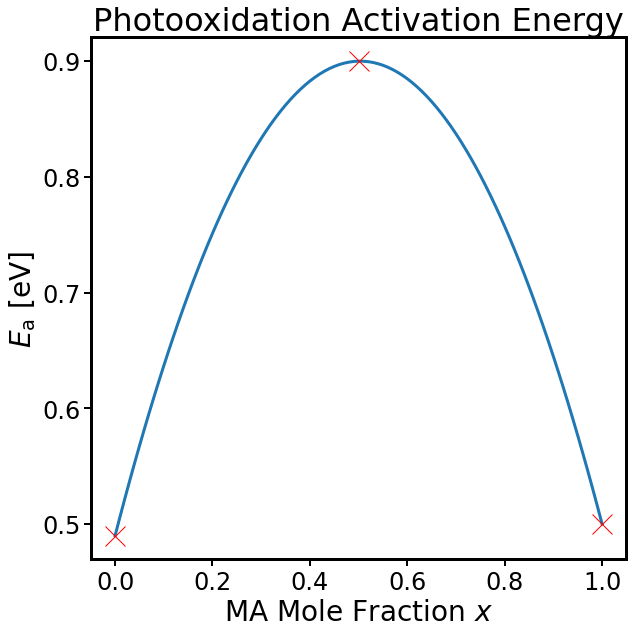

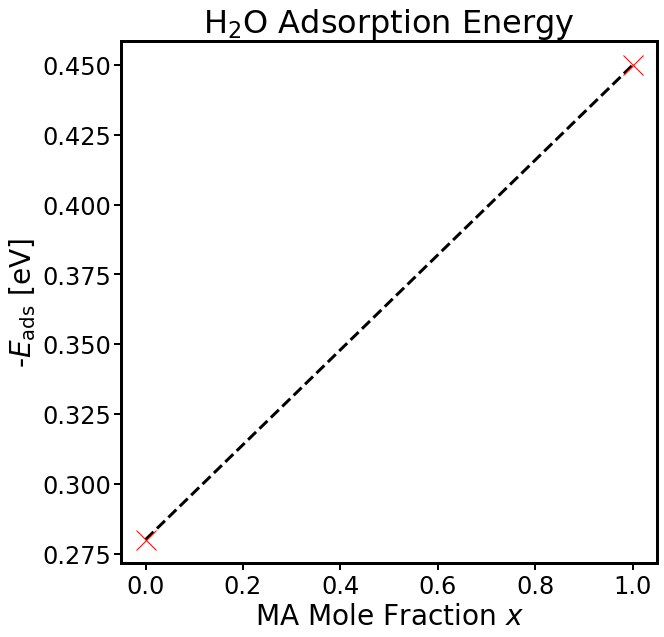

<Figure size 691.2x691.2 with 0 Axes>

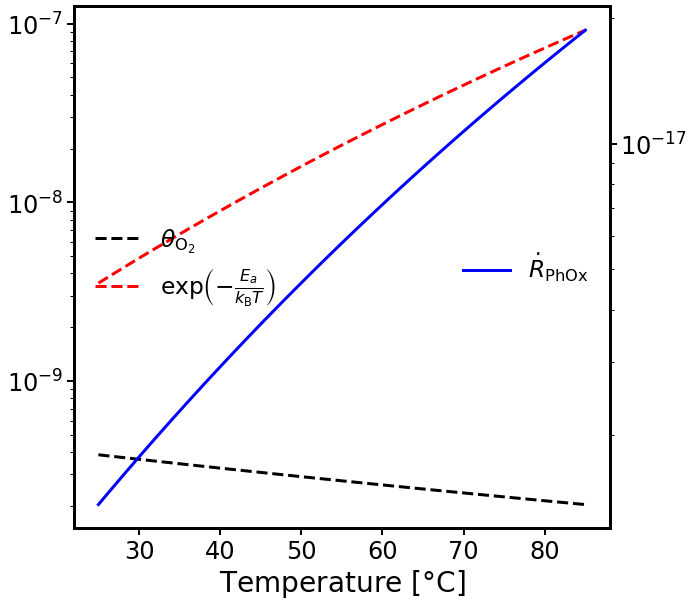

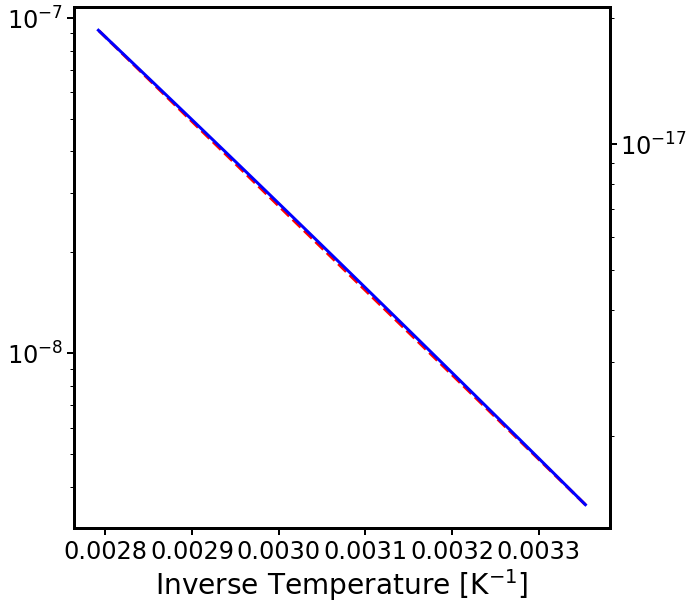

In [8]:
mpl.style.use('wiley_publication.mplstyle')
plt.figure()
#plt.plot(rawdata_df['MA fraction'],rawdata_df['Ea_O2 (eV)'],'.')
x_meas = np.array([0,0.5,1])
Ea_meas = np.array([0.49,0.9,0.5])
Ea_fit = np.polyfit(x_meas,Ea_meas,2)
x_fit = np.linspace(0,1,num=101)
plt.plot(x_fit,Ea_fit[0]*x_fit**2 + Ea_fit[1]*x_fit + Ea_fit[2])
plt.plot(x_meas,Ea_meas,'r',marker='x',linestyle='none',markersize=20)
plt.xlabel('MA Mole Fraction $x$')
plt.ylabel('$E_\mathrm{a}$ [eV]')
print(Ea_fit)
#plt.legend(['Rough Fit','Exact Fit','Data'],frameon=False)
plt.title('Photooxidation Activation Energy')

plt.figure()
x_lims = [0,1]
Eads_lims = np.array([-0.28,-0.45])
plt.plot(x_lims,-Eads_lims,'k--')
plt.plot(x_lims,-Eads_lims,'r',marker='x',linestyle='none',markersize=20)
plt.xlabel('MA Mole Fraction $x$')
plt.ylabel('-$E_\mathrm{ads}$ [eV]')
plt.title('H$_2$O Adsorption Energy')

plt.figure()
T_Kelvin = np.linspace(25+273.15,85+273.15,num=101)
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(0.19*(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)
P_use = 101325*0.21
LAI_O2_general = Keq_O2*P_use/(1+Keq_O2*P_use)
Arrhenius_O2 = np.exp(-0.5/(8.617e-5*(T_Kelvin)))
PhOx_rate = LAI_O2_general*Arrhenius_O2

fig, ax = plt.subplots()
ax.semilogy(T_Kelvin-273.15,LAI_O2_general,'k--')
ax.semilogy(T_Kelvin-273.15,Arrhenius_O2,'r--')
ax2 = ax.twinx()
ax2.semilogy(T_Kelvin-273.15,PhOx_rate,'b-')
ax.set_xlabel('Temperature [$\degree$C]')
ax.legend(['$\\theta_\mathrm{O_2}$',
           'exp$\left(-\\frac{E_{a}}{k_\mathrm{B}T}\\right)$'],loc='center left',frameon=False)
ax2.legend(['$\dot{R}_\mathrm{PhOx}$'],loc='center right',frameon=False)

newfig, newax = plt.subplots()
newax.semilogy(T_Kelvin**-1,Arrhenius_O2,'r--')
newax2 = newax.twinx()
newax2.semilogy(T_Kelvin**-1,PhOx_rate,'b-')
newax.set_xlabel('Inverse Temperature [K$^{-1}$]')

In [9]:
PhOx_rate

array([1.36550091e-18, 1.40997374e-18, 1.45568746e-18, 1.50267037e-18,
       1.55095127e-18, 1.60055945e-18, 1.65152468e-18, 1.70387723e-18,
       1.75764786e-18, 1.81286786e-18, 1.86956899e-18, 1.92778355e-18,
       1.98754437e-18, 2.04888477e-18, 2.11183861e-18, 2.17644029e-18,
       2.24272473e-18, 2.31072742e-18, 2.38048434e-18, 2.45203208e-18,
       2.52540773e-18, 2.60064898e-18, 2.67779405e-18, 2.75688173e-18,
       2.83795139e-18, 2.92104297e-18, 3.00619698e-18, 3.09345453e-18,
       3.18285728e-18, 3.27444751e-18, 3.36826808e-18, 3.46436245e-18,
       3.56277467e-18, 3.66354941e-18, 3.76673195e-18, 3.87236815e-18,
       3.98050452e-18, 4.09118816e-18, 4.20446682e-18, 4.32038885e-18,
       4.43900323e-18, 4.56035960e-18, 4.68450820e-18, 4.81149992e-18,
       4.94138631e-18, 5.07421952e-18, 5.21005239e-18, 5.34893840e-18,
       5.49093166e-18, 5.63608696e-18, 5.78445974e-18, 5.93610610e-18,
       6.09108281e-18, 6.24944729e-18, 6.41125766e-18, 6.57657268e-18,
      

Text(0, 0.5, '$\\ln(t_{L_\\mathrm{D},75})$')

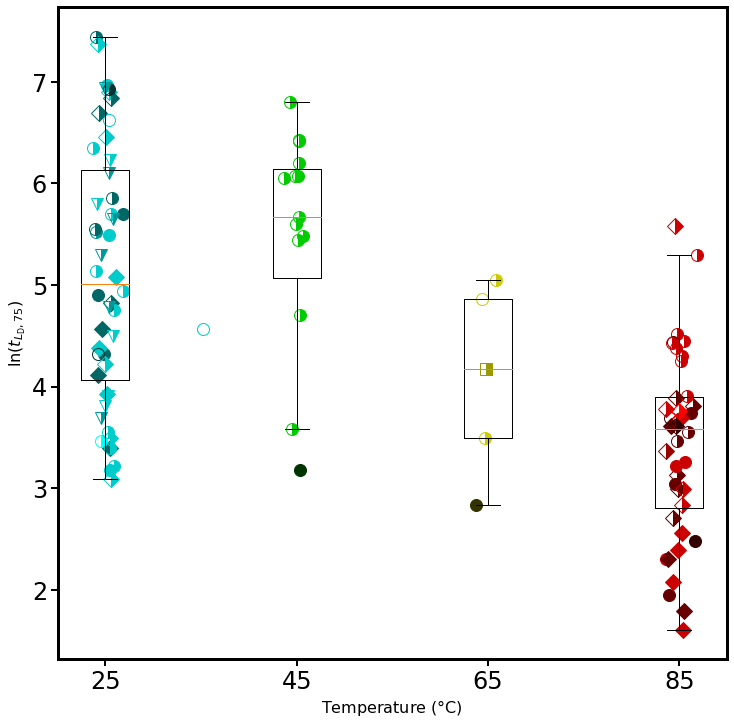

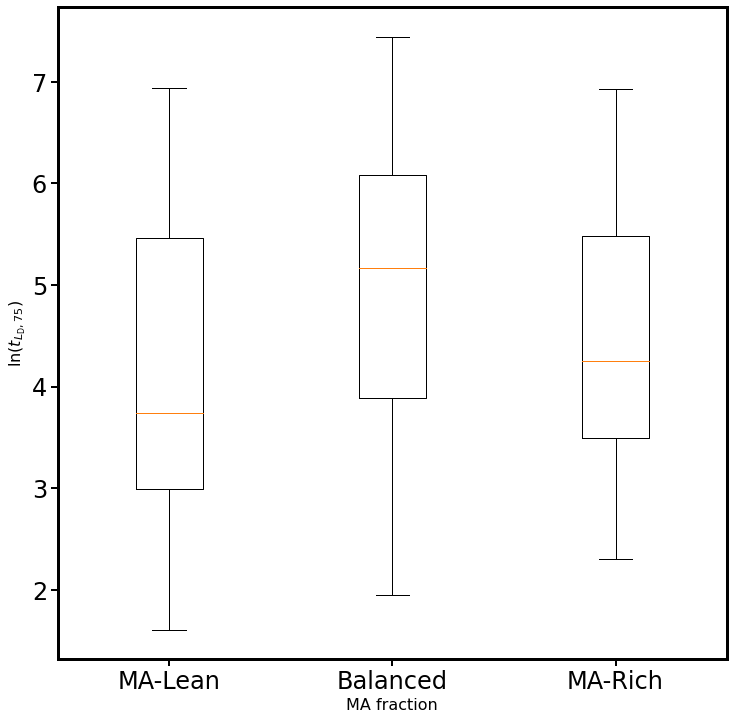

In [10]:
import random
fig, ax = plt.subplots(figsize=(12,12))

T25 = []
T45 = []
T65 = []
T85 = []

for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    #y = rawdata_df['tLD75 (min)'][ii]
    y = np.log(rawdata_df['tLD75 (min)'].iloc[ii])
    #y = np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'][ii])
    #y = np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'][ii])
    #y = rawdata_df['Ld5'][ii]
    
    ax.plot(rawdata_df['Temp (deg C)'].iloc[ii]+random.gauss(0,0.75),y,
             color=color,fillstyle=fill,marker=marker,linestyle=style)
    if T < 35:
        if not np.isnan(y):
            T25.append(y)
    elif T < 55:
        if not np.isnan(y):
            T45.append(y)
    elif T < 75:
        if not np.isnan(y):
            T65.append(y)
    else:
        if not np.isnan(y):
            T85.append(y)

ax.boxplot([T25,T45,T65,T85],positions=[25,45,65,85],widths=[5,5,5,5],showfliers=False)
ax.set_xlim([20,90])
ax.set_xlabel('Temperature ($\degree$C)',fontsize=16)
ax.set_ylabel('$\ln(t_{L_\mathrm{D},75})$',fontsize=16)

fig2, ax2 = plt.subplots(figsize=(12,12))

MA_rich = []
MA_bal = []
MA_lean = []

for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    #y = rawdata_df['tLD75 (min)'][ii]
    y = np.log(rawdata_df['tLD75 (min)'].iloc[ii])
    #y = np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'][ii])
    #y = np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'][ii])
    #y = rawdata_df['Ld5'][ii]
    
    #ax2.plot(rawdata_df['MA fraction'].iloc[ii]+random.gauss(0,0.01),y,
    #         color=color,fillstyle=fill,marker=marker,linestyle=style)
    if xMA < 0.33:
        if not np.isnan(y):
            MA_lean.append(y)
    elif xMA >= 0.33 and xMA < 0.66:
        if not np.isnan(y):
            MA_bal.append(y)
    else:
        if not np.isnan(y):
            MA_rich.append(y)

#ax2.boxplot([MA_lean,MA_bal,MA_rich],positions=[0,0.5,1],widths=[0.05,0.05,0.05],showfliers=False)
ax2.boxplot([MA_lean,MA_bal,MA_rich],labels=['MA-Lean','Balanced','MA-Rich'],showfliers=False)
#ax2.set_xlim([20,90])
ax2.set_xlabel('MA fraction',fontsize=16)
ax2.set_ylabel('$\ln(t_{L_\mathrm{D},75})$',fontsize=16)


# Filter the Dataset to Remove Unwanted Conditions

Current strategy for the paper is to avoid runs at intermediate temperature, unless things really fall apart. We are also eschewing runs in N2 for the time being.

In [12]:
# In this cell, filter out parts of the dataset that we aren't allowed to use (mostly 45C runs, but also some N2 runs)

# filter by temperature
# illegal_temps = [45,65]
# for temp in illegal_temps:
#     rawdata_df = rawdata_df[rawdata_df['Temp (deg C)'] != temp]

# filter by atmosphere
rawdata_df = rawdata_df[rawdata_df['Oxygen (%)'] > 0]

# display reduced DF
rawdata_df

Unnamed: 0                                            ClassID  \
0             0  191203_Single_Sample_PL_PC_T_Combinatorial_Str...   
1             1  191203_Single_Sample_PL_PC_T_Combinatorial_Str...   
2             2  191203_Single_Sample_PL_PC_T_Combinatorial_Str...   
3             3  191203_Single_Sample_PL_PC_T_Combinatorial_Str...   
4             4  191203_Single_Sample_PL_PC_T_Combinatorial_Str...   
..          ...                                                ...   
120         120                               200709_Modeling_Runs   
123         123                               200709_Modeling_Runs   
125         125                           200520_Composition_Study   
126         126                           200520_Composition_Study   
127         127                           200520_Composition_Study   

                                              ExptID  Temp (deg C)  RH (%)  \
0      PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap          25.0    63.1   
1      PL_PC_T_FAPIBr3_8Sun_85C_60RH_21pctO2_Unencap          85.0    63.1   
2      PL_PC_T_FAPIBr3_8Sun_85C_20RH_21pctO2_Unencap          85.0    24.8   
3     PL_PC_T_FAPIBr3_32Sun_85C_60RH_21pctO2_Unencap          85.0    58.6   
4    PL_PC_T_FAPIBr3_8Sun_25C_60RH_21pctO2_Unencap_3          25.0    58.4   
..                                               ...           ...     ...   
120                     PL_PC_T_MAPI_8Sun_65C_0RH_O2          65.0     0.0   
123                     PL_PC_T_MAPI_8Sun_85C_0RH_O2          85.0     0.0   
125                   PL_PC_T_FACs_8Sun_45C_60RH_air          45.0    58.0   
126                   PL_PC_T_x300_1Sun_25C_45RH_air          25.0    47.5   
127                   PL_PC_T_FACs_8Sun_65C_60RH_air          65.0    58.0   

     Oxygen (%)  Illum (Nsuns)  MA fraction  Bleach Rate (polyfit) (1/min)  \
0            21              8          0.0                      -0.000577   
1            21              8          0.0                       0.010670   
2            21              8          0.0                       0.008912   
3            21             32          0.0                       0.008145   
4            21              8          0.0                       0.000541   
..          ...            ...          ...                            ...   
120         100              8          1.0                       0.003286   
123         100              8          1.0                       0.022396   
125          21              8          0.0                      -0.000627   
126          21              1          0.7                       0.003068   
127          21              8          0.0                      -0.000232   

     Bleach Rate (1% inc) (1/min)  ...   Tr_4min   Tr_6min   Tr_8min  \
0                        0.000305  ...  0.997481  0.998565  0.998421   
1                        0.012720  ...  1.048872  1.069412  1.084717   
2                        0.009993  ...  1.037454  1.054929  1.071653   
3                        0.009853  ...  1.032864  1.046677  1.060056   
4                        0.000516  ...  1.001828  1.003186  1.004989   
..                            ...  ...       ...       ...       ...   
120                      0.003105  ...  1.013042  1.022209  1.032592   
123                      0.019885  ...  1.089508  1.143653  1.204556   
125                      0.000215  ...  0.993887  0.993071  0.991637   
126                      0.003945  ...  1.015779  1.023669  1.031558   
127                      0.000501  ...  0.995439  0.990471  0.992729   

     Tr_10min        P_H2O       P_O2  Ea_O2 (eV)  PhotoOx_rate  \
0    0.999056  1992.653044   21278.25      0.4900  2.607553e-14   
1    1.105353  1992.653044   21278.25      0.4900  9.718528e-14   
2    1.086230   783.166331   21278.25      0.4900  9.718528e-14   
3    1.073443  1850.546250   21278.25      0.4900  3.887411e-13   
4    1.006791  1844.230393   21278.25      0.4900  2.607553e-14   
..        ...          

In [115]:
# and save master list, if desired
#savepath = 'C:/Users/Wiley Dunlap-Shohl/Desktop/Just in Case/Calculations/hp-db/hp-db/Ld/'
#savename = '200720_Featurized_Data_For_Paper_MASTER_LIST.csv'
#rawdata_df.to_csv(savepath+savename)

# Make Basic Plots of the Dataset

Before modeling, it is always advisable to analyze the dataset by visualization to better contextualize the predictions of the model. Here is where we make some plots for figures in the paper. 

Text(0, 0.5, '$L_\\mathrm{D}$ at  $t\\ =\\ 0$ [nm]')

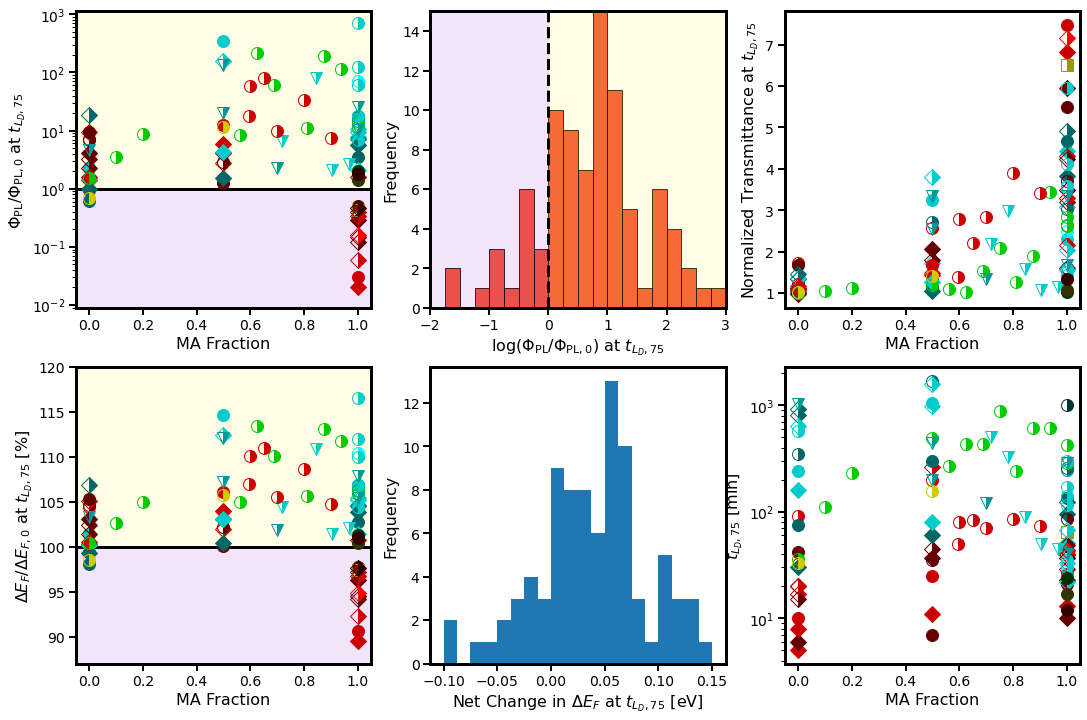

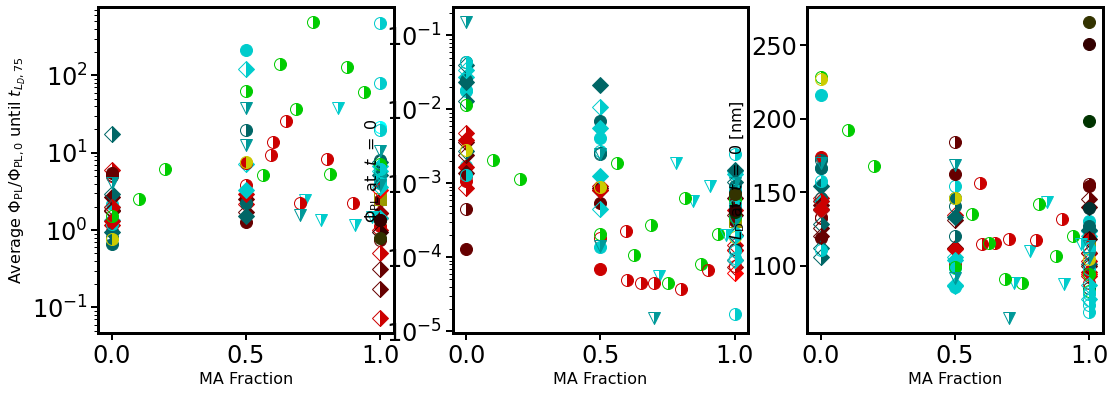

In [13]:
# Make some plots of the overall dataset
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(18,12))

def_fontsize = 16
def_labelsize = 14

ax00_xmin = -0.05
ax00_xmax = 1.05
ax00_ymin = 10**-2.05
ax00_ymax = 10**3.05

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,0].hlines(1,ax00_xmin,ax00_xmax,color='k',linestyles='-') # boundary
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymax,ax00_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymin,ax00_ymin],color=(0.56,0,0.8,0.1)) # darkened region

for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    ax[0,0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax[1,0].plot(rawdata_df['MA fraction'].iloc[ii],100*(1 + 0.059*np.log10(rawdata_df['PLFail'].iloc[ii]/rawdata_df['QFLS_0'].iloc[ii])), 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax[0,2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['TrFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax[1,2].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['tLD75 (min)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)

ax[0,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,0].set_ylabel('$\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,0].set_xlim(ax00_xmin,ax00_xmax)
ax[0,0].set_ylim(ax00_ymin,ax00_ymax)


ax10_xmin = -0.1
ax10_xmax = 1.1
ax10_ymin = 85
ax10_ymax = 120
ax[1,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,0].set_ylabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,75}$ [%]',fontsize=def_fontsize)


ax[1,0].hlines(100,ax10_xmin,ax10_xmax,color='k',linestyles='-') # boundary
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymax,ax10_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymin,ax10_ymin],color=(0.56,0,0.8,0.1)) # darkened region
ax[1,0].set_xlim([-0.05,1.05])
ax[1,0].set_ylim([87,120])

ax[0,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,2].set_ylabel('Normalized Transmittance at $t_{L_D,75}$',fontsize=def_fontsize)

ax[1,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,2].set_ylabel('$t_{L_D,75}$ [min]',fontsize=def_fontsize)


ax[0,1].hist(np.log10(rawdata_df['PLFail'].dropna()),bins=np.linspace(-2,3,num=21),
             color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[0,1].set_xlabel('log($\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$) at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,1].set_ylabel('Frequency',fontsize=def_fontsize)

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,1].vlines(0,0,15,color='k',linestyles='--')
ax[0,1].fill([0,0,3,3],[0,15,15,0],color=(1,0.96,0,0.1)) # brightened region
ax[0,1].fill([0,0,-2,-2],[0,15,15,0],color=(0.56,0,0.8,0.1)) # brightened region
ax[0,1].set_xlim(-2,3)
ax[0,1].set_ylim(0,15)

ax[1,1].hist(0.059*np.log10(rawdata_df['PLFail']),bins=np.linspace(-0.1,0.15,num=21))
ax[1,1].set_xlabel('Net Change in $\Delta E_F$ at $t_{L_D,75}$ [eV]',fontsize=def_fontsize)
ax[1,1].set_ylabel('Frequency',fontsize=def_fontsize)

for ii in range(2):
    for jj in range(3):
        ax[ii,jj].tick_params(axis='x', labelsize=def_labelsize)
        ax[ii,jj].tick_params(axis='y', labelsize=def_labelsize)

fig2,ax2 = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    ax2[0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLEnhance'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[1].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLQY_0'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['LD_0 (nm)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
ax2[0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[0].set_ylabel('Average $\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ until $t_{L_D,75}$',fontsize=def_fontsize)
    
ax2[1].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[1].set_ylabel('$\Phi_\mathrm{PL}$ at  $t\ =\ 0$',fontsize=def_fontsize)    

ax2[2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[2].set_ylabel('$L_\mathrm{D}$ at  $t\ =\ 0$ [nm]',fontsize=def_fontsize)



[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.563, 0.594, 0.6, 0.625, 0.65, 0.688, 0.7, 0.7, 0.7190000000000001, 0.75, 0.7809999999999999, 0.8, 0.813, 0.8440000000000001, 0.875, 0.9, 0.9059999999999999, 0.938, 0.9690000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


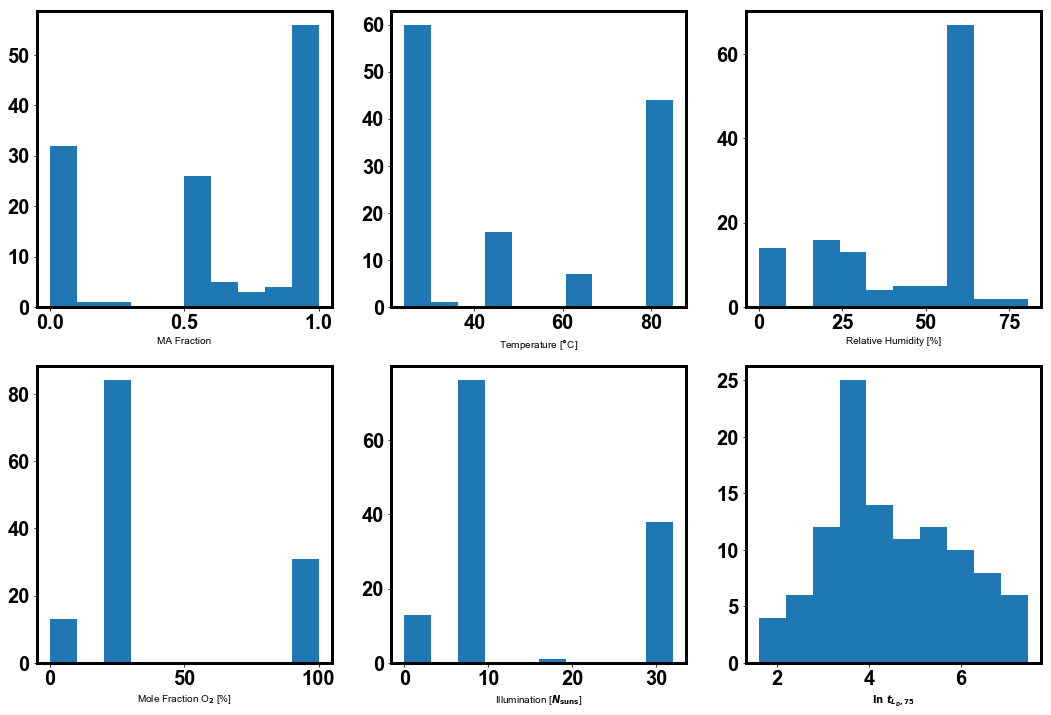

In [19]:
# Plot histograms of the dataset
fig3,ax3 = plt.subplots(nrows=2,ncols=3,figsize=(18,12))

ax3[0,0].hist(rawdata_df['MA fraction'].values)
ax3[0,0].set_xlabel('MA Fraction')

ax3[0,1].hist(rawdata_df['Temp (deg C)'].values)
ax3[0,1].set_xlabel('Temperature [$\degree$C]')

ax3[0,2].hist(rawdata_df['RH (%)'].values)
ax3[0,2].set_xlabel('Relative Humidity [%]')

ax3[1,0].hist(rawdata_df['Oxygen (%)'].values)
ax3[1,0].set_xlabel('Mole Fraction O$_2$ [%]')

ax3[1,1].hist(rawdata_df['Illum (Nsuns)'].values)
ax3[1,1].set_xlabel('Illumination [$N_\mathrm{suns}$]')

ax3[1,2].hist(np.log(rawdata_df['tLD75 (min)'].values))
ax3[1,2].set_xlabel('$\mathrm{ln}\ t_{L_D,75}$')

MA_fracs_sorted = list(rawdata_df['MA fraction'].values)
MA_fracs_sorted.sort()
print(MA_fracs_sorted)

# Feature Pre-Selection:

In this cell, set up the machine learning task by deciding which of the above attributes to use as the response (i.e., variable to predict) and which to use as the features and which to ignore. It is also possible to construct interaction-related features, such as those between environment and composition.

In [15]:
# change to True if using a log transform on the response
Log_transform = True

# choose the bleaching rate calculation to use as the response
#response = 'Bleach Rate (fit to 5% inc) (1/min)' 
# response = 'Bleach Rate (polyfit) (1/min)' 
response = 'tLD75 (min)'
#response = 'tPLmax'
#response = 'PL0'
# assign factor labels to each stress
factor_dict = {'A':'Temp (deg C)',
               'B':'RH (%)',
               'C':'Oxygen (%)',
               'D':'Illum (Nsuns)',
               'E':'MA fraction',
               'dTrdt':'Bleach Rate (polyfit) (1/min)',
               'dLDdt':'dLDdt (1/min)',
               'dPLdt':'dPLdt (1/min)',
               'LD0':'LD_0 (nm)',
               'PL0':'PLQY_0'}

factor_dict_inv = {'Temp (deg C)':'A',
                   'RH (%)':'B',
                   'Oxygen (%)':'C',
                   'Illum (Nsuns)':'D',
                   'MA fraction':'E',
                   'Bleach Rate (polyfit) (1/min)':'dTrdt',
                   'dLDdt (1/min)':'dLDdt',
                   'dPLdt (1/min)':'dPLdt',
                   'LD_0 (nm)':'LD0',
                   'PLQY_0':'PL0'}

# choose environment, composition, AND early time features

# PL heterogeneity terms to choose from:
#'xy1t0_0','xy0t1_0','xy0t1Norm_0','xy1t1_0','t0xy1_0','t1xy0_0','frac_bright_0'
spatiotemporal = ['xy1t0_0','xy0t1_0','xy1t1_0','t0xy1_0','t1xy0_0','frac_bright_0']
# Features used in the ACSEL paper
Ryan_features = ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E',]
#                 'PhotoOx_rate','Hydration_rate']
#                 'PhotoOx_rate','Hydration_rate','delS_mix',]


#Ryan_features = ['dTrdt','dLDdt','dPLdt',
#                 'ddTr0','ddLD0','ddPL0',
#                 'Ld_2min','Ld_4min','Ld_6min','Ld_8min','Ld_10min',
#                 'PL_2min','PL_4min','PL_6min','PL_8min','PL_10min',
#                 'Tr_2min','Tr_4min','Tr_6min','Tr_8min','Tr_10min',
#                 'A','B','C','D','E']

#Ryan_features = ['dTrdt','dLDdt','dPLdt',
#                 'ddTr0','ddLD0','ddPL0',]
#                 'A','B','C','D','E']

#Ryan_features = ['A','B','C','D','E']
#Ryan_features = ['A','P_H2O','P_O2','D','E']
# Decide which features to use in the model

#terms_to_keep = ['A','B','C','D','E','dTrdt','dLDdt','dPLdt','LD0','PL0','frac_bright_0',response]
#terms_to_keep = ['A','B','C','D','E','dTrdt','dLDdt','dPLdt','LD0','PL0','ddTr0','ddLD0','ddPL0',response]$t
#terms_to_keep = ['A','B','C','D','E','dTrdt','dLDdt','dPLdt','LD0','PL0','xy1t1_0',response]
#terms_to_keep = ['A','B','C','D','E','dTrdt','dLDdt','dPLdt','LD0','PL0',response]
# envt, composition ONLY
#terms_to_keep = ['A','B','C','D','E',response]
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# Filter results by temperature: keep only runs at less than 50C
#coded_df = coded_df[coded_df['Temp (deg C)'] < 50]
#print('Number of Runs Below 45 C:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows in which the response is not successfully calculated (no predictive value)
#coded_df = coded_df.dropna(subset=[response])

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

# logarithmize spatiotemporal features
for term in spatiotemporal:
    try:
        coded_df[term] = np.log(coded_df[term])
    except:
        pass

# construct two-factor interactions 
#TODO: figure out a way to do this automatically
# enumerate combinations of parameters, respecting alphabetical order
# prepare list of these combinations up to the desired order (2nd, 3rd, etc.)
# construct multilinear factor
# iterate over factors
n_factors = len(terms_to_keep)
"""singletons = list(factor_dict.keys)
all_interactions = singletons.copy()
order = n_factors # counter-like variable that tracks order of the 
                  # factors being constructed in the while loop
while order ~= 1:
    for jj in range(order):
        new_factor = 
    order -= 1"""

if terms_to_keep != Ryan_features + [response]:
    # do it the dumb way for now
    coded_df.insert(n_factors,'AB',coded_df['A']*coded_df['P_H2O'])
    coded_df.insert(n_factors+1,'AC',coded_df['A']*coded_df['P_O2'])
    coded_df.insert(n_factors+2,'AD',coded_df['A']*coded_df['D'])
    coded_df.insert(n_factors+3,'AE',coded_df['A']*coded_df['E'])
    coded_df.insert(n_factors+4,'BC',coded_df['P_H2O']*coded_df['P_O2'])
    coded_df.insert(n_factors+5,'BD',coded_df['P_H2O']*coded_df['D'])
    coded_df.insert(n_factors+6,'BE',coded_df['P_H2O']*coded_df['E'])
    coded_df.insert(n_factors+7,'CD',coded_df['P_O2']*coded_df['D'])
    coded_df.insert(n_factors+8,'CE',coded_df['P_O2']*coded_df['E'])
    coded_df.insert(n_factors+9,'DE',coded_df['D']*coded_df['E'])
    # quadratic factors of composition
    coded_df.insert(n_factors+10,'EE',coded_df['E']*coded_df['E'])
    #coded_df.insert(n_factors+11,'AEE',coded_df['A']*coded_df['E']*coded_df['E'])

    # insert quadratic factor of temperature - does not seem to work especially well
    coded_df.insert(n_factors+11,'AA',coded_df['A']*coded_df['A'])
    coded_df.insert(n_factors+12,'BB',coded_df['P_H2O']*coded_df['P_H2O'])
    coded_df.insert(n_factors+13,'CC',coded_df['P_O2']*coded_df['P_O2'])
    coded_df.insert(n_factors+14,'DD',coded_df['D']*coded_df['D'])
    #coded_df.insert(n_factors+12,'|dtdTr|', np.abs(coded_df['dTrdt']**-1))
    #coded_df.insert(n_factors+11,'A-1',coded_df['A']**-1)
   
coded_df.head()

Number of Runs Total: 115
Number of Runs That Fail After Prediction Horizon: 96


A   D    E     dTrdt  tLD75 (min)     dLDdt     dPLdt     ddTr0  \
1  85.0   8  0.0  0.010670         92.0  0.008114  0.218308 -0.000597   
2  85.0   8  0.0  0.008912         32.0  0.002890  0.495270 -0.000204   
3  85.0  32  0.0  0.008145         17.0  0.008179  0.839965 -0.000637   
5  85.0   8  0.0  0.006697         10.0 -0.030735  0.002259 -0.000506   
6  25.0   8  0.0 -0.000362        243.0  0.002932  0.038540  0.000094   

      ddPL0     ddLD0  ...       Tr3       Tr4       Tr5       PL1       PL2  \
1  0.001112  0.000797  ...  1.069412  1.084717  1.105353  1.368863  1.859022   
2 -0.022958 -0.000757  ...  1.054929  1.071653  1.086230  1.957788  3.259413   
3  0.068016 -0.004294  ...  1.025606  1.032864  1.039976  1.562190  2.494719   
5  0.007580  0.001224  ...  1.021188  1.026873  1.032995  0.967473  0.988206   
6 -0.006965 -0.000170  ...  0.995036  0.995460  0.995773  1.316676  1.391801   

        PL3       PL4       PL5        P_H2O       P_O2  
1  2.323938  2.705538  3.006719  1992.653044   21278.25  
2  4.266671  4.798263  5.118519   783.166331   21278.25  
3  3.430654  4.265591  5.061981  1850.546250   21278.25  
5  0.999425  0.995317  0.981292  1894.757253  101325.00  
6  1.449345  1.511762  1.565128  1913.704825  101325.00  

[5 rows x 27 columns]

ValueError: x and y must have same first dimension, but have shapes (115,) and (128,)

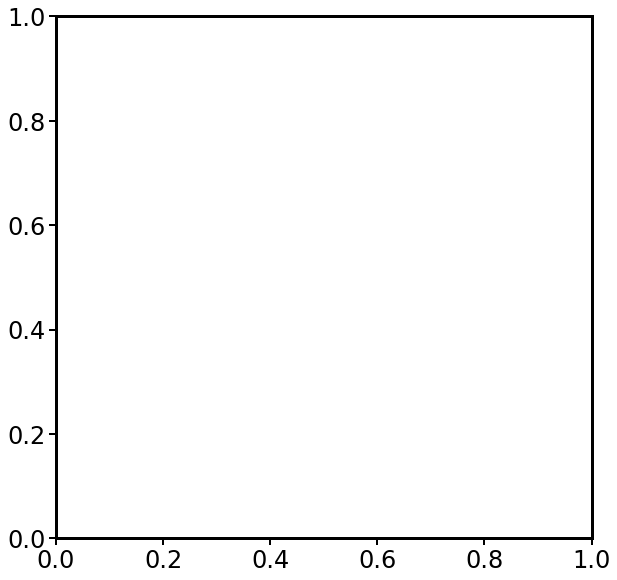

In [16]:
plt.plot(rawdata_df['MA fraction'],LAI_H2O,'.')

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.max_rows
pd.options.display.max_columns
coded_df

A   D      E     dTrdt  tLD75 (min)     dLDdt     dPLdt     ddTr0  \
1    85.0   8  0.000  0.010670         92.0  0.008114  0.218308 -0.000597   
2    85.0   8  0.000  0.008912         32.0  0.002890  0.495270 -0.000204   
3    85.0  32  0.000  0.008145         17.0  0.008179  0.839965 -0.000637   
5    85.0   8  0.000  0.006697         10.0 -0.030735  0.002259 -0.000506   
6    25.0   8  0.000 -0.000362        243.0  0.002932  0.038540  0.000094   
8    25.0  32  0.000 -0.000247        160.0 -0.002024  0.003923  0.000040   
9    25.0   8  0.000 -0.000155         75.0 -0.007281 -0.017357  0.000022   
10   25.0  32  0.000  0.000118         30.0 -0.011390 -0.001173  0.000049   
12   25.0   8  0.000 -0.000091        350.0 -0.004437 -0.008428  0.000022   
13   85.0  32  0.000  0.004099         15.0 -0.006232  0.053102  0.000414   
14   85.0   8  0.000  0.013879         42.0  0.019395  0.980057 -0.002026   
15   25.0  32  0.000  0.000029        807.0  0.005004  0.439099  0.000067   
17   85.0  32  0.000  0.016663          6.0 -0.037193  0.650885  0.000036   
18   25.0  32  1.000  0.026062         51.0  0.020924  0.399304  0.000981   
19   25.0  32  1.000  0.032154         33.0  0.023972  0.318816  0.001606   
20   25.0  32  1.000  0.007659        125.0  0.042274  0.317856  0.000413   
21   25.0  32  1.000  0.008171         96.0  0.017676  0.218345  0.000630   
22   25.0   8  1.000  0.026814         24.0 -0.001009  0.110083  0.001133   
23   85.0   8  1.000  0.099800         26.0  0.040359  0.053750  0.005015   
24   85.0  32  1.000  0.123545         13.0  0.066615  0.218082  0.012336   
25   25.0  32  0.000 -0.000329        635.0  0.003224  0.027188  0.000041   
26   85.0   8  1.000  0.109678         21.0  0.012342  0.332510  0.007416   
27   85.0  32  1.000  0.024960         23.0 -0.044466 -0.210187 -0.000724   
28   85.0  32  1.000  0.018715         39.0 -0.034851 -0.191506 -0.000003   
29   85.0   8  1.000  0.021729         85.0 -0.009064 -0.051556 -0.000379   
30   85.0  32  1.000  0.142842         10.0  0.011619  0.257808  0.016931   
31   25.0   8  1.000  0.006908        135.0  0.000754  0.185467  0.000234   
33   25.0  32  0.500  0.007462        995.0  0.008916  0.091116 -0.000115   
34   85.0  32  0.500  0.005319        265.0  0.000115  0.018879 -0.000051   
35   85.0  32  0.500  0.028258         37.0  0.004121 -0.008166 -0.000425   
36   25.0  32  0.000  0.001913        935.0  0.000893  0.026229 -0.000101   
38   85.0   8  0.500  0.019116          7.0 -0.028188  0.093919 -0.000830   
40   85.0   8  0.500  0.016539        199.0  0.005883 -0.138600  0.000375   
41   85.0   8  0.500  0.014914         35.0  0.000321  0.170902 -0.000616   
42   25.0  32  0.500  0.002589         61.0 -0.008706  0.084411 -0.000429   
43   25.0   8  0.500  0.001968        300.0  0.006523  0.021514  0.000053   
44   85.0   8  0.500  0.041229         25.0  0.009244  0.623741 -0.002434   
45   85.0  32  0.500  0.036757         11.0 -0.018425  0.419954 -0.001488   
49   25.0   8  0.000 -0.000245        570.0 -0.000807  0.000535  0.000032   
50   25.0   8  0.500  0.004900       1065.0  0.001196  0.042675  0.000217   
51   24.2   8  0.500  0.001986       1710.0  0.003642  0.079649  0.000080   
52   25.0  32  0.500  0.005476         80.0 -0.003258  0.036068 -0.000149   
57   65.0  16  1.000  0.023495         65.0  0.012592  0.144281  0.000666   
58   85.0  32  1.000  0.029437         29.0  0.010210  0.102848  0.000435   
59   85.0  32  1.000  0.022607         40.0 -0.016537 -0.093627  0.000474   
60   85.0  32  1.000  0.032858         44.0 -0.017553  0.133394  0.001462   
61   85.0  32  1.000  0.022069         49.0 -0.017441 -0.131137  0.000378   
62   25.0   8  1.000  0.015877        116.0  0.002417 -0.008212  0.001087   
63   85.0  32  1.000  0.036666         43.0  0.000554  0.521729  0.001018   
64   85.0  32  1.000  0.031414         37.0  0.004180  0.214544  0.002558   
65   25.0   8  1.000  0.000070       1020.0  0.008875  0.026821  0.000033   
66  

{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}
70

C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



For test set:
Mean of Mean Absolute Error = 17.5 %
Median of Mean Absolute Error = 13.3 %
Std. Dev. of Mean Absolute Error = 16.6 %
Mean of Mean Absolute Error = 0.701
Median of Mean Absolute Error = 0.56
Std. Dev. of Mean Absolute Error = 0.548
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 14.2 %
Median of Mean Absolute Error = 14.2 %
Std. Dev. of Mean Absolute Error = 0.1 %
Mean of Mean Absolute Error = 0.578
Median of Mean Absolute Error = 0.579
Std. Dev. of Mean Absolute Error = 0.006
Mean R2 = 0.7426
Median R2 = 0.7423
Std Dev. R2 = 0.0069
Mean Linear Error = 97.0 %
Median Linear Error = 54.0 %
{'alpha': 0.039810717055349734}


<ipython-input-18-684165ac0fe2>:367: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


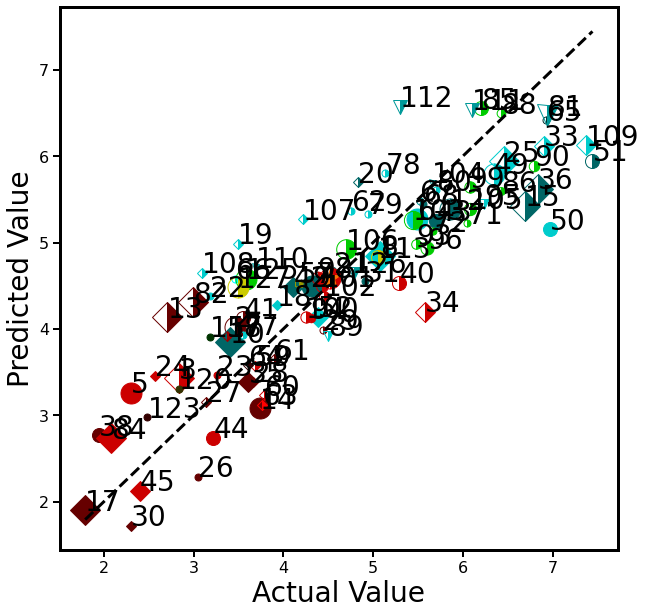

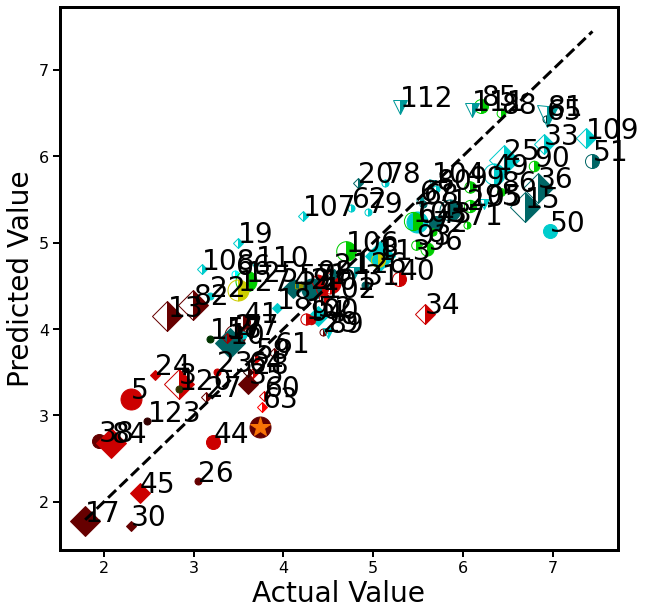

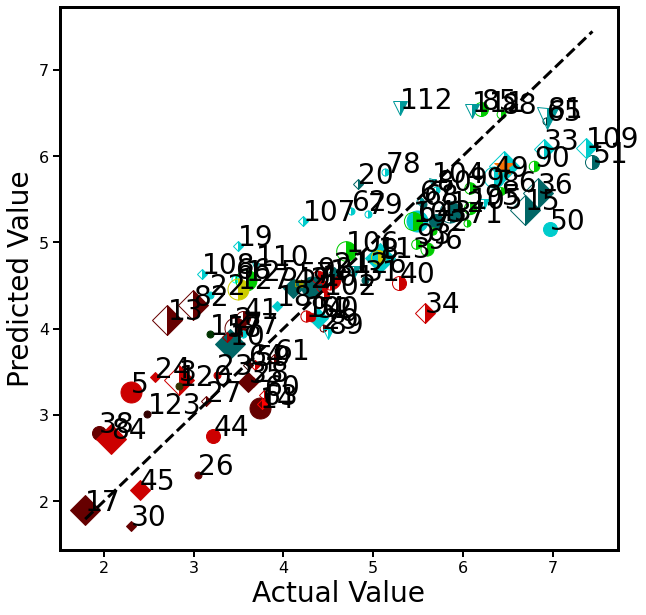

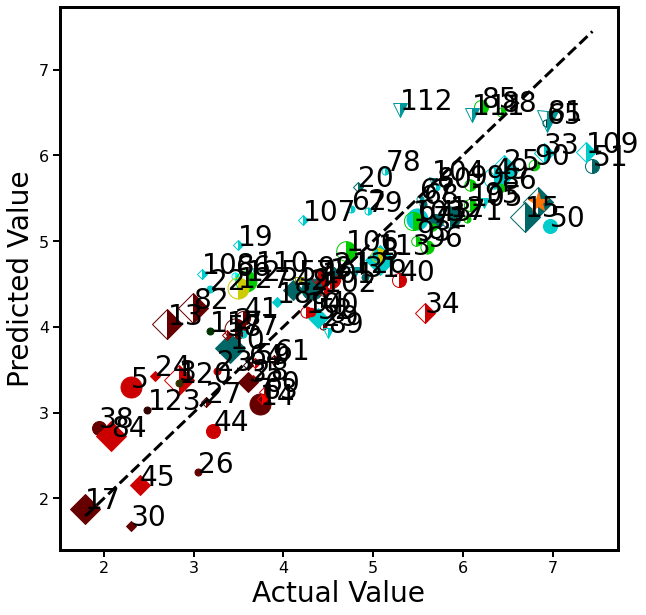

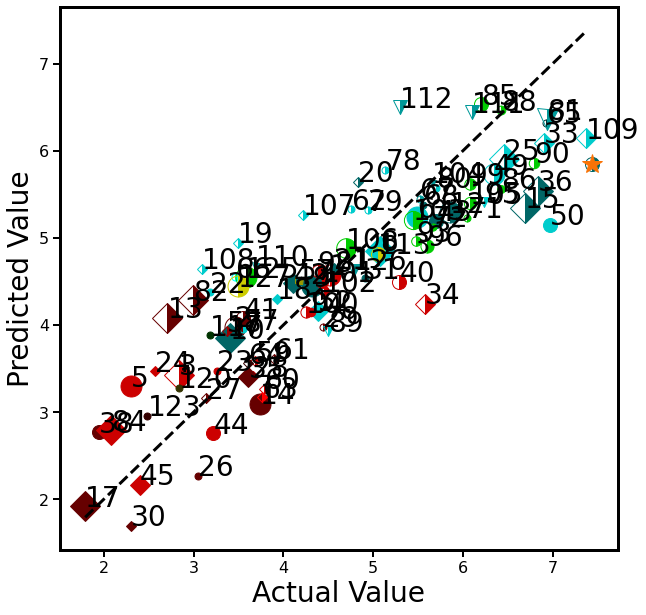

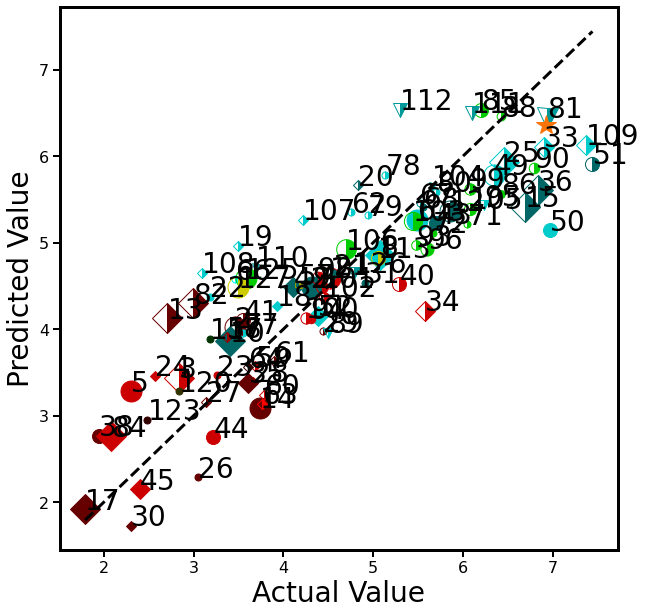

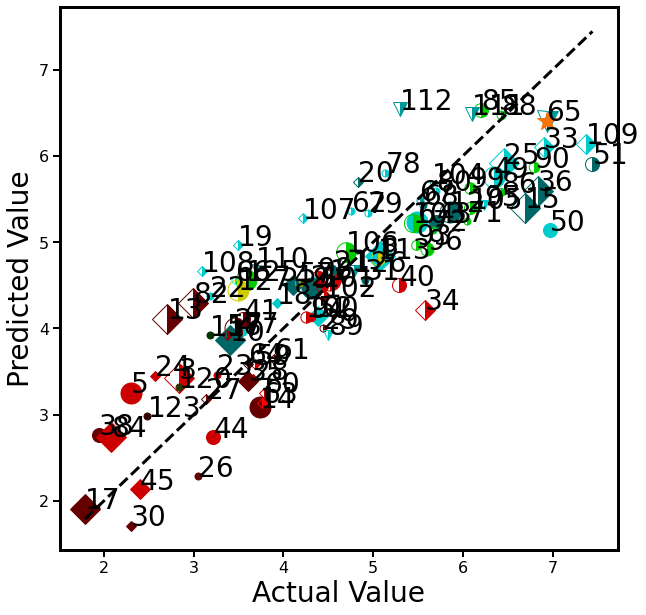

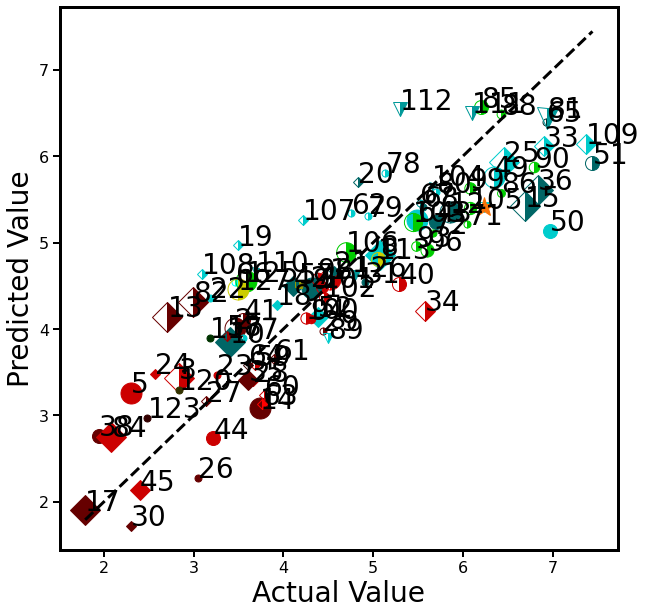

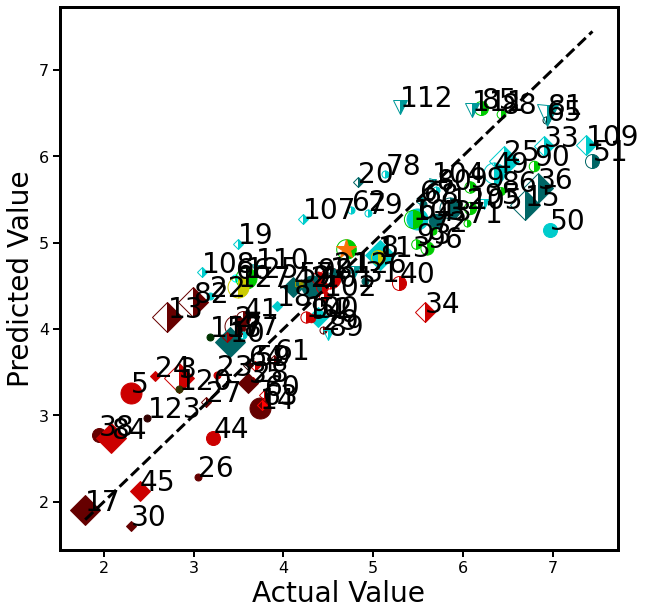

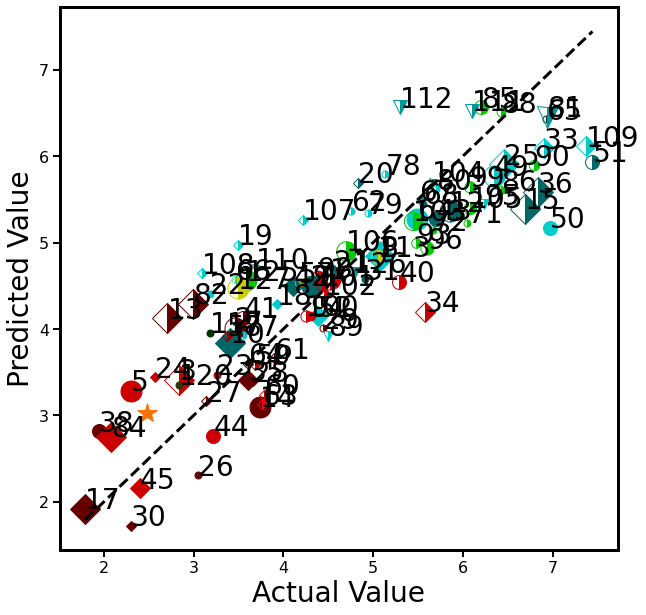

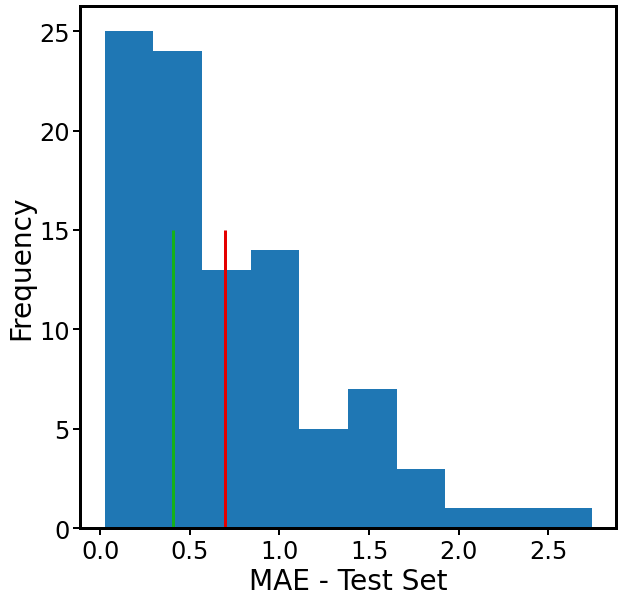

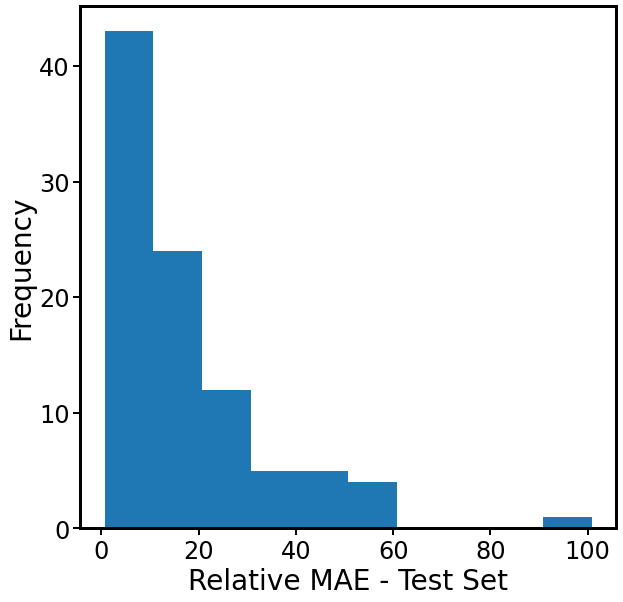

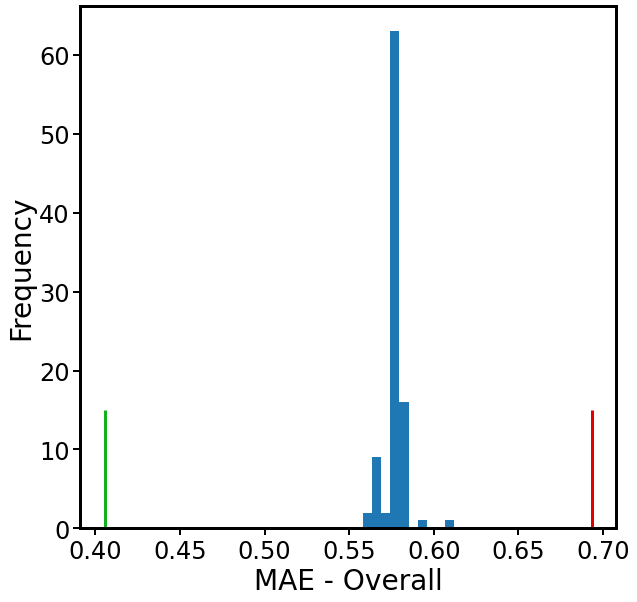

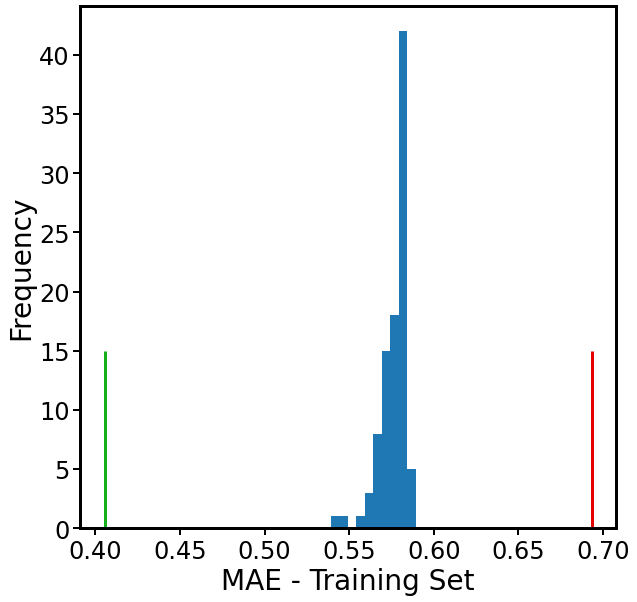

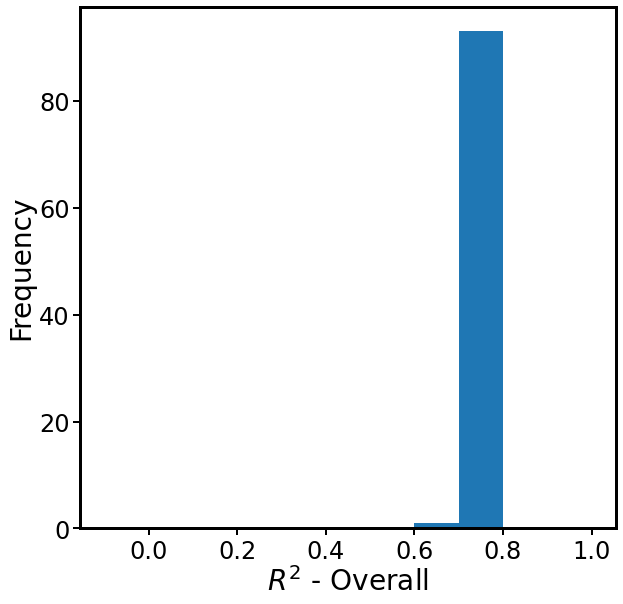

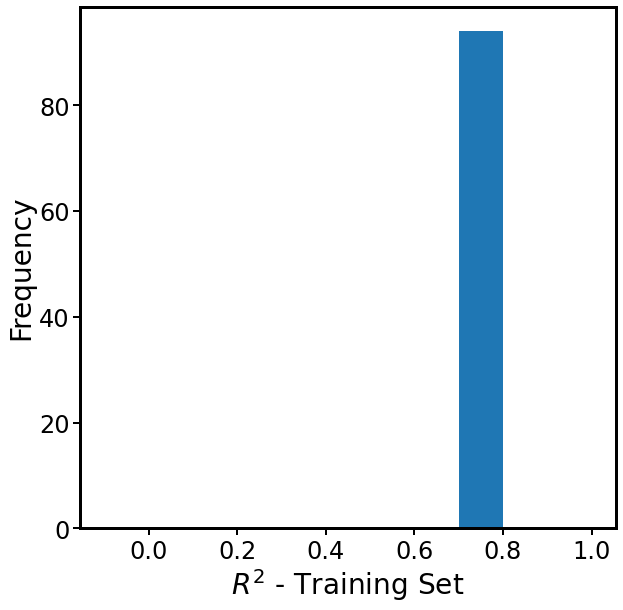

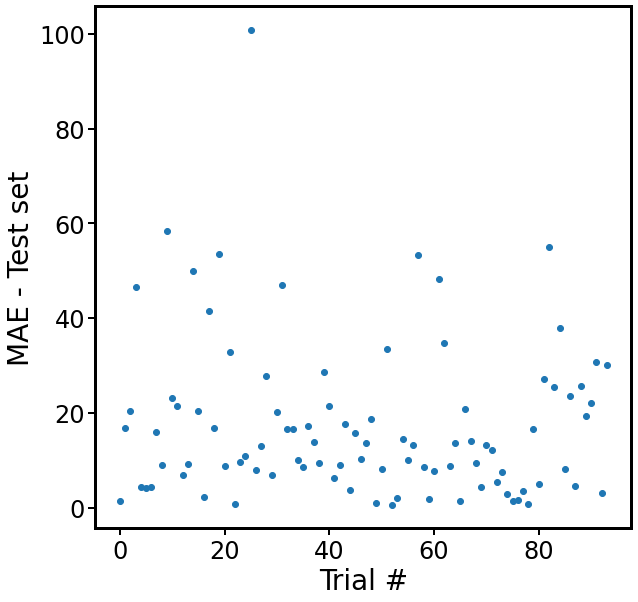

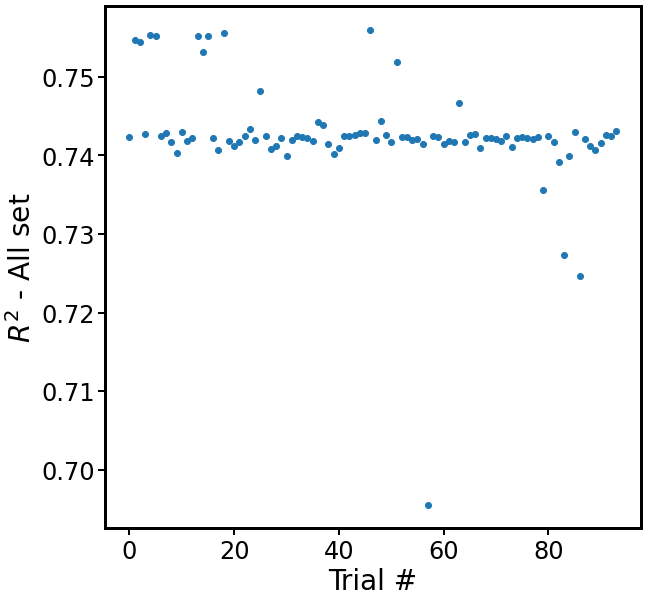

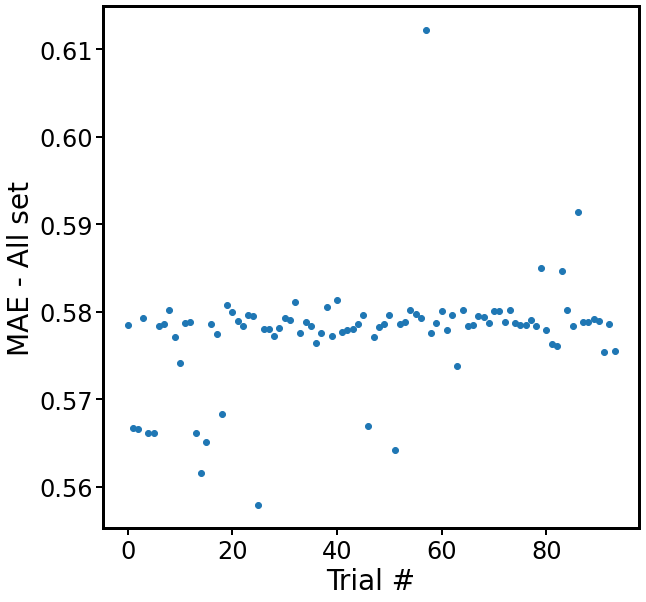

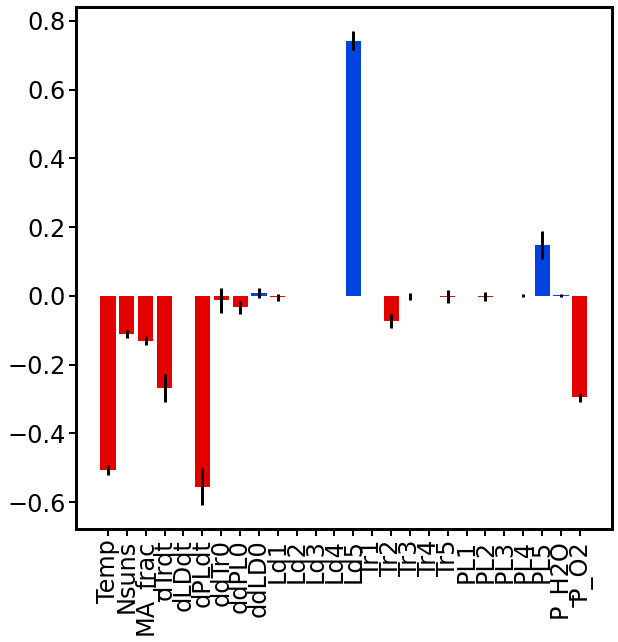

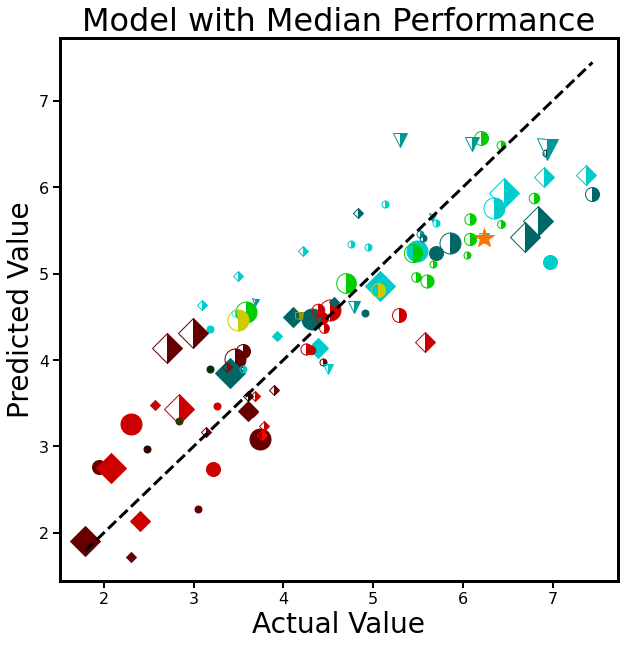

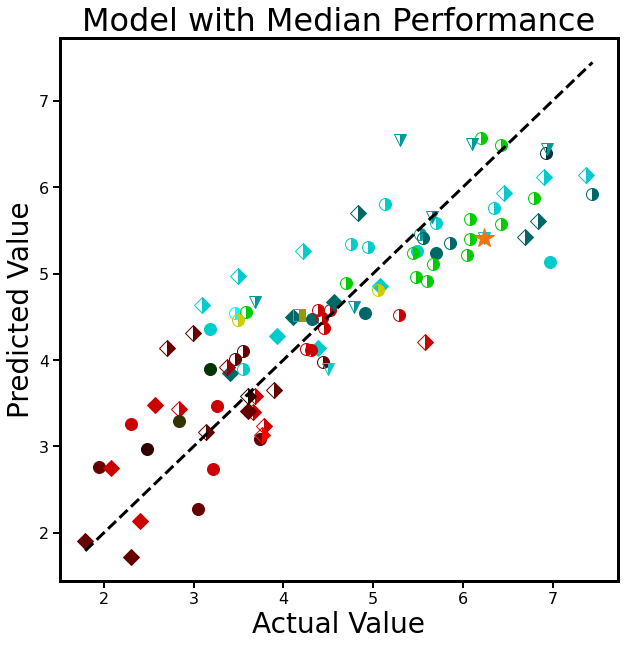

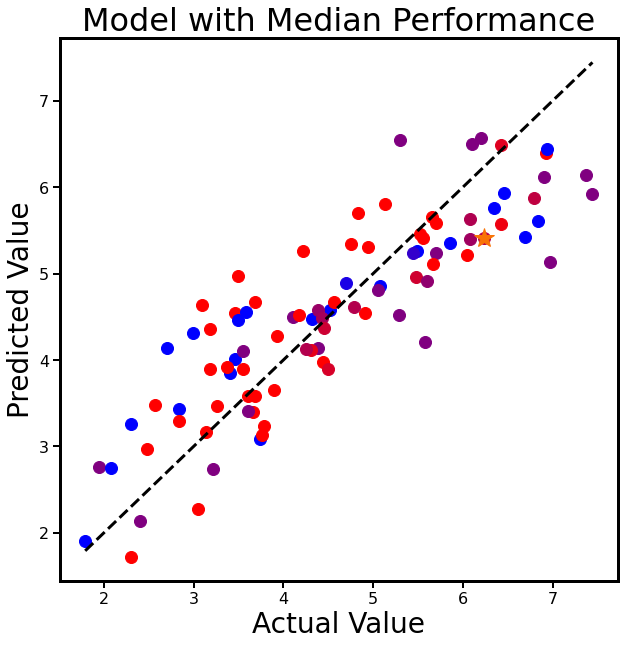

In [18]:
# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)
#n_trials=5

# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = 5

# initialize error metrics for test set
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# for the whole dataset
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)

# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):

#kk = 0

    #X_whold = np.array([X[kk,:]])
    #y_whold = np.array([Y[kk]])
    #X_train = np.delete(X,kk,axis=0)
    #y_train = np.delete(Y,kk,axis=0)
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)
    
    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']
    
    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)
    
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    
    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])
    
    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)
    
    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)
    
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    
    # plot training data with markers corresponding to environmental + compositional conditions
    if kk%10 == 0:
        plt.figure(figsize=(10,10))
        for ii in range(len(y_train)):
            idx = y_train.index[ii]
            #T = X[factor_dict_inv['Temp (deg C)']][idx]
            #RH = X[factor_dict_inv['RH (%)']][idx]
            #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
            #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
            T = rawdata_df['Temp (deg C)'][idx]
            RH = rawdata_df['RH (%)'][idx]
            pct_O2 = rawdata_df['Oxygen (%)'][idx]
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            #MA_frac = X[factor_dict_inv['MA fraction']][idx]
            MA_frac = rawdata_df['MA fraction'][idx]
            plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            plt.text(y_train.loc[idx],ytpred[ii],idx)
        ''' for jj in range(len(coded_df[response].values)):
                if Log_transform:
                    to_match = np.log(np.abs(coded_df[response].values[jj]))
                else:
                    to_match = np.abs(coded_df[response].values[jj])

                if y_train[ii] == to_match:
                    T = coded_df[factor_dict_inv['Temp (deg C)']].values[jj]
                    RH = coded_df[factor_dict_inv['RH (%)']].values[jj]
                    pct_O2 = coded_df[factor_dict_inv['Oxygen (%)']].values[jj]
                    N_suns_stress = coded_df[factor_dict_inv['Illum (Nsuns)']].values[jj]
                    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
                    MA_frac = coded_df[factor_dict_inv['MA fraction']].values[jj]
                    break'''
            
        # plot perfect prediction line and +/-50% error bounds
        plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
        plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
        
        plt.xlabel('Actual Value')
        plt.ylabel('Predicted Value')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        # plot test data as above
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii]
            #T = X[factor_dict_inv['Temp (deg C)']][idx]
            #RH = X[factor_dict_inv['RH (%)']][idx]
            #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
            #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
            T = rawdata_df['Temp (deg C)'][idx]
            RH = rawdata_df['RH (%)'][idx]
            pct_O2 = rawdata_df['Oxygen (%)'][idx]
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            #MA_frac = X[factor_dict_inv['MA fraction']][idx]
            MA_frac = rawdata_df['MA fraction'][idx]
            plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

plt.figure()
plt.hist(MAE)
plt.xlabel('MAE - Test Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

plt.figure()
plt.hist(MAE_pct)
plt.xlabel('Relative MAE - Test Set')
plt.ylabel('Frequency')


plt.figure()
plt.hist(MAE_overall)
plt.xlabel('MAE - Overall')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

plt.figure()
plt.hist(MAE_train)
plt.xlabel('MAE - Training Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

plt.figure()
plt.hist(R2_overall,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Overall')
plt.ylabel('Frequency')

plt.figure()
plt.hist(R2_train,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Training Set')
plt.ylabel('Frequency')


plt.figure()
plt.plot(range(n_trials),MAE_pct,'.')
plt.xlabel('Trial #')
plt.ylabel('MAE - Test set')

plt.figure()
plt.plot(range(n_trials),R2_overall,'.')
plt.xlabel('Trial #')
plt.ylabel('$R^2$ - All set')

plt.figure()
plt.plot(range(n_trials),MAE_overall,'.')
plt.xlabel('Trial #')
plt.ylabel('MAE - All set')

plt.figure()

new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}

second_order_dict = {
    'AA':'Temp^2',
    'AB':'Temp*RH',
    'AC':'Temp*O2',
    'AD':'Temp*Nsuns',
    'AE':'Temp*MA_frac',
    'BC':'RH*O2',
    'BD':'RH*Nsuns',
    'BE':'RH*MA_frac',
    'CD':'O2*Nsuns',
    'CE':'O2*MA_frac',
    'DE':'Nsuns*MA_frac',
    'EE':'MA_frac^2'
}

coeffs_df.rename(columns = new_dict, inplace = True)
try:
    coeffs_df.rename(columns = second_order_dict, inplace = True)
except:
    pass

coeffs = coeffs_df.columns

avgs = np.mean(coeffs_df)
error = np.std(coeffs_df)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

plt.bar(coeffs,avgs,yerr=error,color=bar_colors)
plt.xticks(rotation=90)

idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
print(idx)

print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
print('Median Linear Error =',np.round(np.median(linear_error)),'%')

'''for key in coeffs_df.columns:
    plt.figure(figsize=(10,2))
    plt.plot(range(n_trials),coeffs_df[key],'.')
    plt.xlabel('Trial #')
    plt.ylabel(key)'''

##### Below this line is the code for plotting the performance of the median model

# plot the median model
kk = idx
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()

# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
ytpred=final_model.predict(X_train)

####### PLOT THE MEDIAN MODEL ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    
####### PLOT THE MEDIAN MODEL - ALTERNATIVE STYLE ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

##### COMPOSITION AS ONLY DISTINGUISHING FEATURE    

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 

In [327]:
bar_colors

['xkcd:red',
 'xkcd:red',
 'xkcd:blue',
 'xkcd:red',
 'xkcd:red',
 'xkcd:red',
 'xkcd:red',
 'xkcd:red',
 'xkcd:blue',
 'xkcd:red',
 'xkcd:blue',
 'xkcd:red',
 'xkcd:red',
 'xkcd:blue',
 'xkcd:red',
 'xkcd:red',
 'xkcd:red',
 'xkcd:blue',
 'xkcd:blue',
 'xkcd:blue',
 'xkcd:red',
 'xkcd:red',
 'xkcd:blue',
 'xkcd:blue',
 'xkcd:blue',
 'xkcd:red',
 'xkcd:red',
 'xkcd:red']

In [29]:
print('Mean Linear Error:',np.mean(linear_error))
print('Median Linear Error:',np.median(linear_error))
print('Number of Trials:',len(linear_error))

Mean Linear Error: 85.182875300471
Median Linear Error: 42.93764170824851
Number of Trials: 99


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 <a list of 28 Text xticklabel objects>)

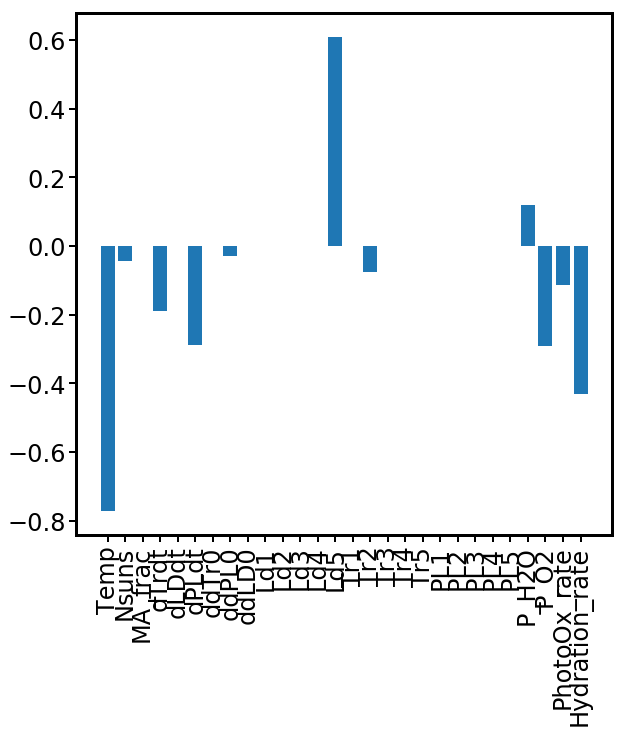

In [325]:
coeffs_df
selected_df = coeffs_df.copy()
for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0
    selected_df.iloc[ii] = logic
stats_df = coeffs_df.copy()
medians = []
means = []
stds = []
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds
plt.bar(stats_df.columns,stats_df.loc['medians'])
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Model Coefficients')

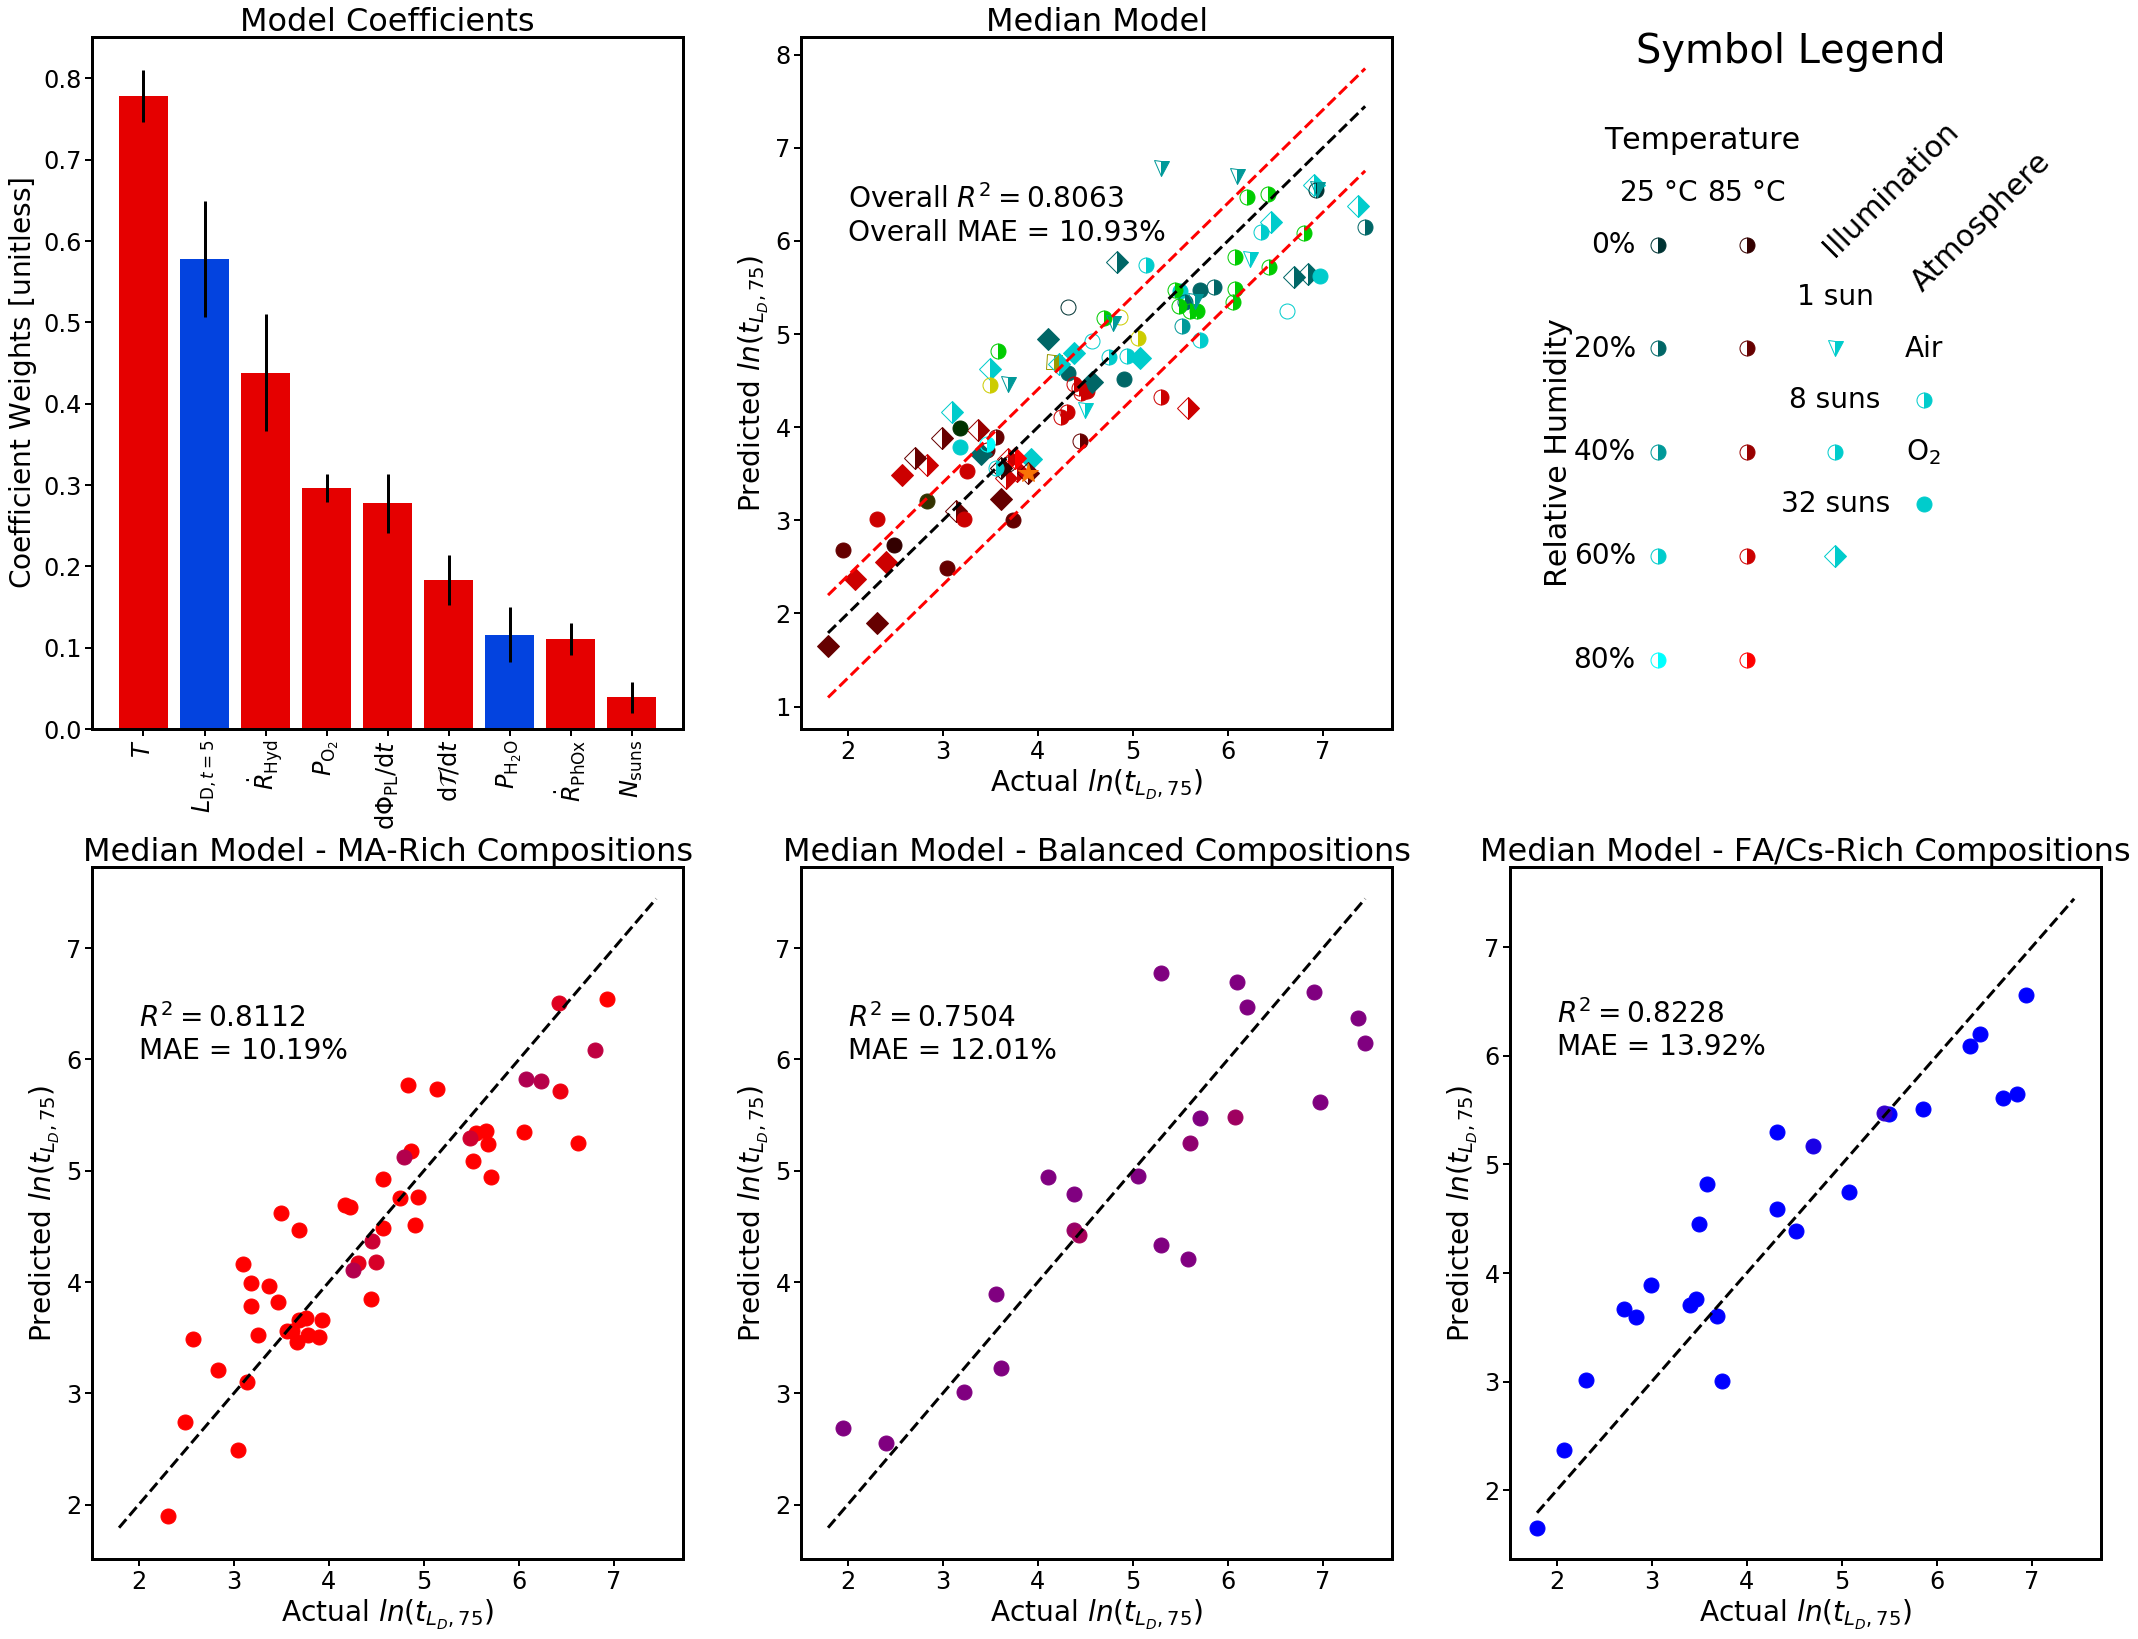

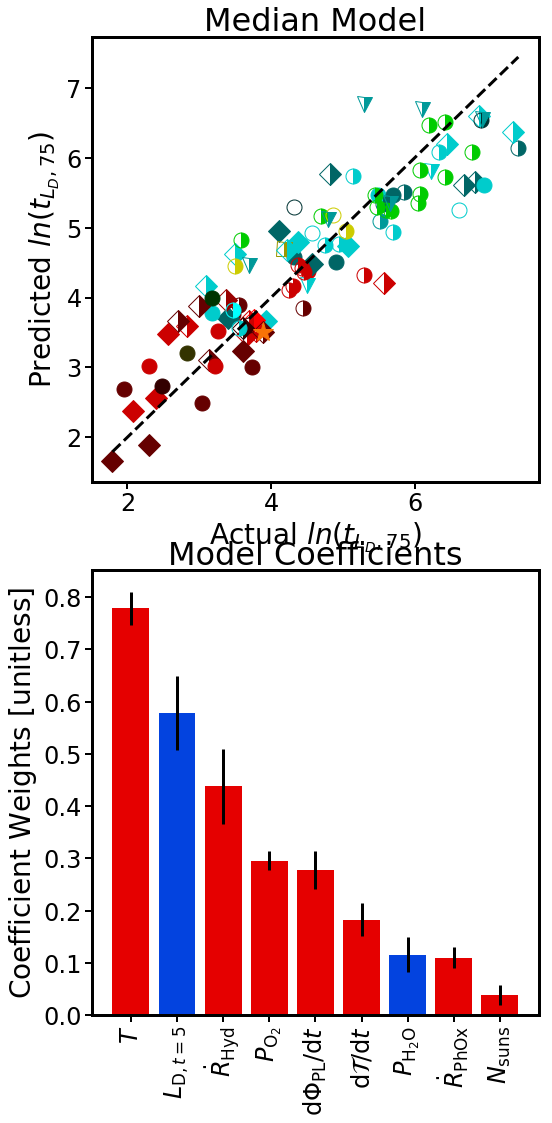

In [316]:
# PLOT FIGURE 3: Modeling Results using only ACSEL Features Set

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(36,28))

##### FIRST PANEL: coefficients

# make a dataframe of coefficients and their labels etc
bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

#ax[0,0].bar(bars_df.index,bars_df['avgs'],yerr=bars_df['error'],color=bars_df['colors'])
#ax[0,0].set_xticklabels(labels=bars_df['coeffs'],rotation=90)

#ax[0,0].bar(nz_bars_df['coeffs'],nz_bars_df['avgs'],yerr=nz_bars_df['error'],color=nz_bars_df['colors'])
#ax[0,0].set_xticklabels(labels=nz_bars_df['coeffs'],rotation=90)
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\dot{R}_\mathrm{Hyd}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$'                     
                    }

'''fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\dot{R}_\mathrm{Hyd}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta \barS^\mathrm{IM}_\mathrm{mix}$' 
                    }'''

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax[0,0].bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[0,0].set_xticklabels(labels=fancy_labels,rotation=90)

ax[0,0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0,0].set_title('Model Coefficients')

##### SECOND PANEL: parity plot of the median model

actual_all = []
preds_all = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    ax[0,1].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0,1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
ax[0,1].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
ax[0,1].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[0,1].set_xlabel('$\mathrm{Actual}\ ln(t_{L_D,75}$)')
ax[0,1].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)')

#ax[0,1].set_xlabel('$\mathrm{Actual\ ln(Bleaching\ Rate})$')
#ax[0,1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax[0,1].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    ax[0,1].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    ax[0,1].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')


actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# for LD modeling - where to put error metrics
text_x = 2
text_y = 6

# for transmittance modeling - where to put error metrics
#text_x = -9
#text_y = -4
    
ax[0,1].text(text_x,text_y,'Overall $R^2 = $' + str(round(R2_overall,4)) + '\n' +\
                 'Overall MAE = ' + str(round(np.mean(MAE_pct_overall),2)) + '%')    
##### THIRD PANEL: Symbol Legend
ax[0,2].axis('off')
ax[0,2].set_xlim([0,10])
ax[0,2].set_ylim([0,10])

origin = (2.5,7)
pitch = 1.5

# plot temperature/humidity symbols
pct_O2 = 21
N_suns_stress = 8
for ii in range(2):
    for jj in range(5):
        T = 25 + ii*60
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[0,2].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0,2].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',ha='center',va='center')
ax[0,2].text(origin[0]+pitch,origin[1]+0.5*pitch,'85 $\degree$C',ha='center',va='center')
ax[0,2].text(origin[0]+0.5*pitch,origin[1]+pitch,'Temperature',fontsize=30,ha='center',va='center')

ax[0,2].text(origin[0]-0.25*pitch,origin[1],'0%',ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',ha='right',va='center')
ax[0,2].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=30,ha='center',va='center',rotation=90)

# plot illumination symbols
T = 25
RH = 60
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+2*pitch,origin[1]-pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+2*pitch,origin[1]-2*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+2*pitch,origin[1]-3*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0,2].text(origin[0]+1.8*pitch,origin[1]-0.25,'Illumination',rotation=45,fontsize=30,va='bottom')
ax[0,2].text(origin[0]+2*pitch,origin[1]-0.5*pitch,'1 sun',ha='center',va='center')
ax[0,2].text(origin[0]+2*pitch,origin[1]-1.5*pitch,'8 suns',ha='center',va='center')
ax[0,2].text(origin[0]+2*pitch,origin[1]-2.5*pitch,'32 suns',ha='center',va='center')

# plot atmosphere symbols
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+3*pitch,origin[1]-1.5*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+3*pitch,origin[1]-2.5*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0,2].text(origin[0]+2.8*pitch,origin[1]-0.75,'Atmosphere',rotation=45,fontsize=30,va='bottom')
ax[0,2].text(origin[0]+3*pitch,origin[1]-pitch,'Air',ha='center',va='center')
ax[0,2].text(origin[0]+3*pitch,origin[1]-2*pitch,'O$_2$',ha='center',va='center')

ax[0,2].text(origin[0]+1.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=40,ha='center')

##### FOURTH PANEL: Parity plot for MA-rich compositions

MA_rich_act = []
MA_rich_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.66:
        MA_rich_act.append(y_train.loc[idx])
        MA_rich_pred.append(ytpred[ii])
        ax[1,0].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1,0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

ax[1,0].set_xlabel('$\mathrm{Actual}\ ln(t_{L_D,75}$)')
ax[1,0].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)')

#ax[1,0].set_xlabel('$\mathrm{Actual\ ln(Bleaching\ Rate})$')
#ax[1,0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate})$')

ax[1,0].set_title('Median Model - MA-Rich Compositions')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.66:
        MA_rich_act.append(y_whold.loc[idx])
        MA_rich_pred.append(ypred[ii])
        ax[1,0].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_rich_act = np.array(MA_rich_act) 
MA_rich_pred = np.array(MA_rich_pred) 
        
        
MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100

ax[1,0].text(text_x,text_y,'$R^2 = $' + str(round(MA_rich_R2,4)) + '\n' +\
                 'MAE = ' + str(round(np.mean(MA_rich_MAE_pct),2)) + '%')

##### FIFTH PANEL: Parity plot for balanced compositions

MA_bal_act = []
MA_bal_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.66 and MA_frac > 0.33:
        MA_bal_act.append(y_train.loc[idx])
        MA_bal_pred.append(ytpred[ii])
        ax[1,1].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1,1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[1,1].set_xlabel('$\mathrm{Actual}\ ln(t_{L_D,75}$)')
ax[1,1].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)')

#ax[1,1].set_xlabel('$\mathrm{Actual\ ln(Bleaching\ Rate)}$')
#ax[1,1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax[1,1].set_title('Median Model - Balanced Compositions')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.66 and MA_frac > 0.33:
        MA_bal_act.append(y_whold.loc[idx])
        MA_bal_pred.append(ypred[ii])
        ax[1,1].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_bal_act = np.array(MA_bal_act) 
MA_bal_pred = np.array(MA_bal_pred) 
        
        
MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
ax[1,1].text(text_x,text_y,'$R^2 = $' + str(round(MA_bal_R2,4)) + '\n' +\
                 'MAE = ' + str(round(np.mean(MA_bal_MAE_pct),2)) + '%')


##### SIXTH PANEL: Parity plot for FACS-rich compositions
MA_lean_act = []
MA_lean_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_train.loc[idx])
        MA_lean_pred.append(ytpred[ii])
        ax[1,2].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1,2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[1,2].set_xlabel('$\mathrm{Actual}\ ln(t_{L_D,75}$)')
ax[1,2].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)')

#ax[1,2].set_xlabel('$\mathrm{Actual\ ln(Bleaching\ Rate)}$')
#ax[1,2].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax[1,2].set_title('Median Model - FA/Cs-Rich Compositions')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_whold.loc[idx])
        MA_lean_pred.append(ypred[ii])
        ax[1,2].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_lean_act = np.array(MA_lean_act) 
MA_lean_pred = np.array(MA_lean_pred) 
        
        
MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
ax[1,2].text(text_x,text_y,'$R^2 = $' + str(round(MA_lean_R2,4)) + '\n' +\
                 'MAE = ' + str(round(np.mean(MA_lean_MAE_pct),2)) + '%')


# Simple Plot of coefficients and parity 
fig2, ax2 = plt.subplots(nrows=2,ncols=1,figsize=(8,18))

actual_all = []
preds_all = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    ax2[0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax2[0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax2[0].set_xlabel('$\mathrm{Actual}\ ln(t_{L_D,75}$)')
ax2[0].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)')

#ax2[0].set_xlabel('$\mathrm{Actual\ ln(Bleaching\ Rate)}$')
#ax2[0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax2[0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    ax2[0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    ax2[0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')


#actual_all = np.array(actual_all)
#preds_all = np.array(preds_all)
#R2_overall = r2_score(actual_all,preds_all)
#MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
    
#ax2[0].text(2,6,'Overall $R^2 = $' + str(round(R2_overall,4)) + '\n' +\
#                 'Overall MAE = ' + str(round(np.mean(MAE_pct_overall),2)) + '%')  

ax2[1].bar(fancy_labels,sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax2[1].set_xticklabels(fancy_labels,rotation=90)

ax2[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax2[1].set_title('Model Coefficients')

Text(0.5, 1.0, 'Model Coefficients')

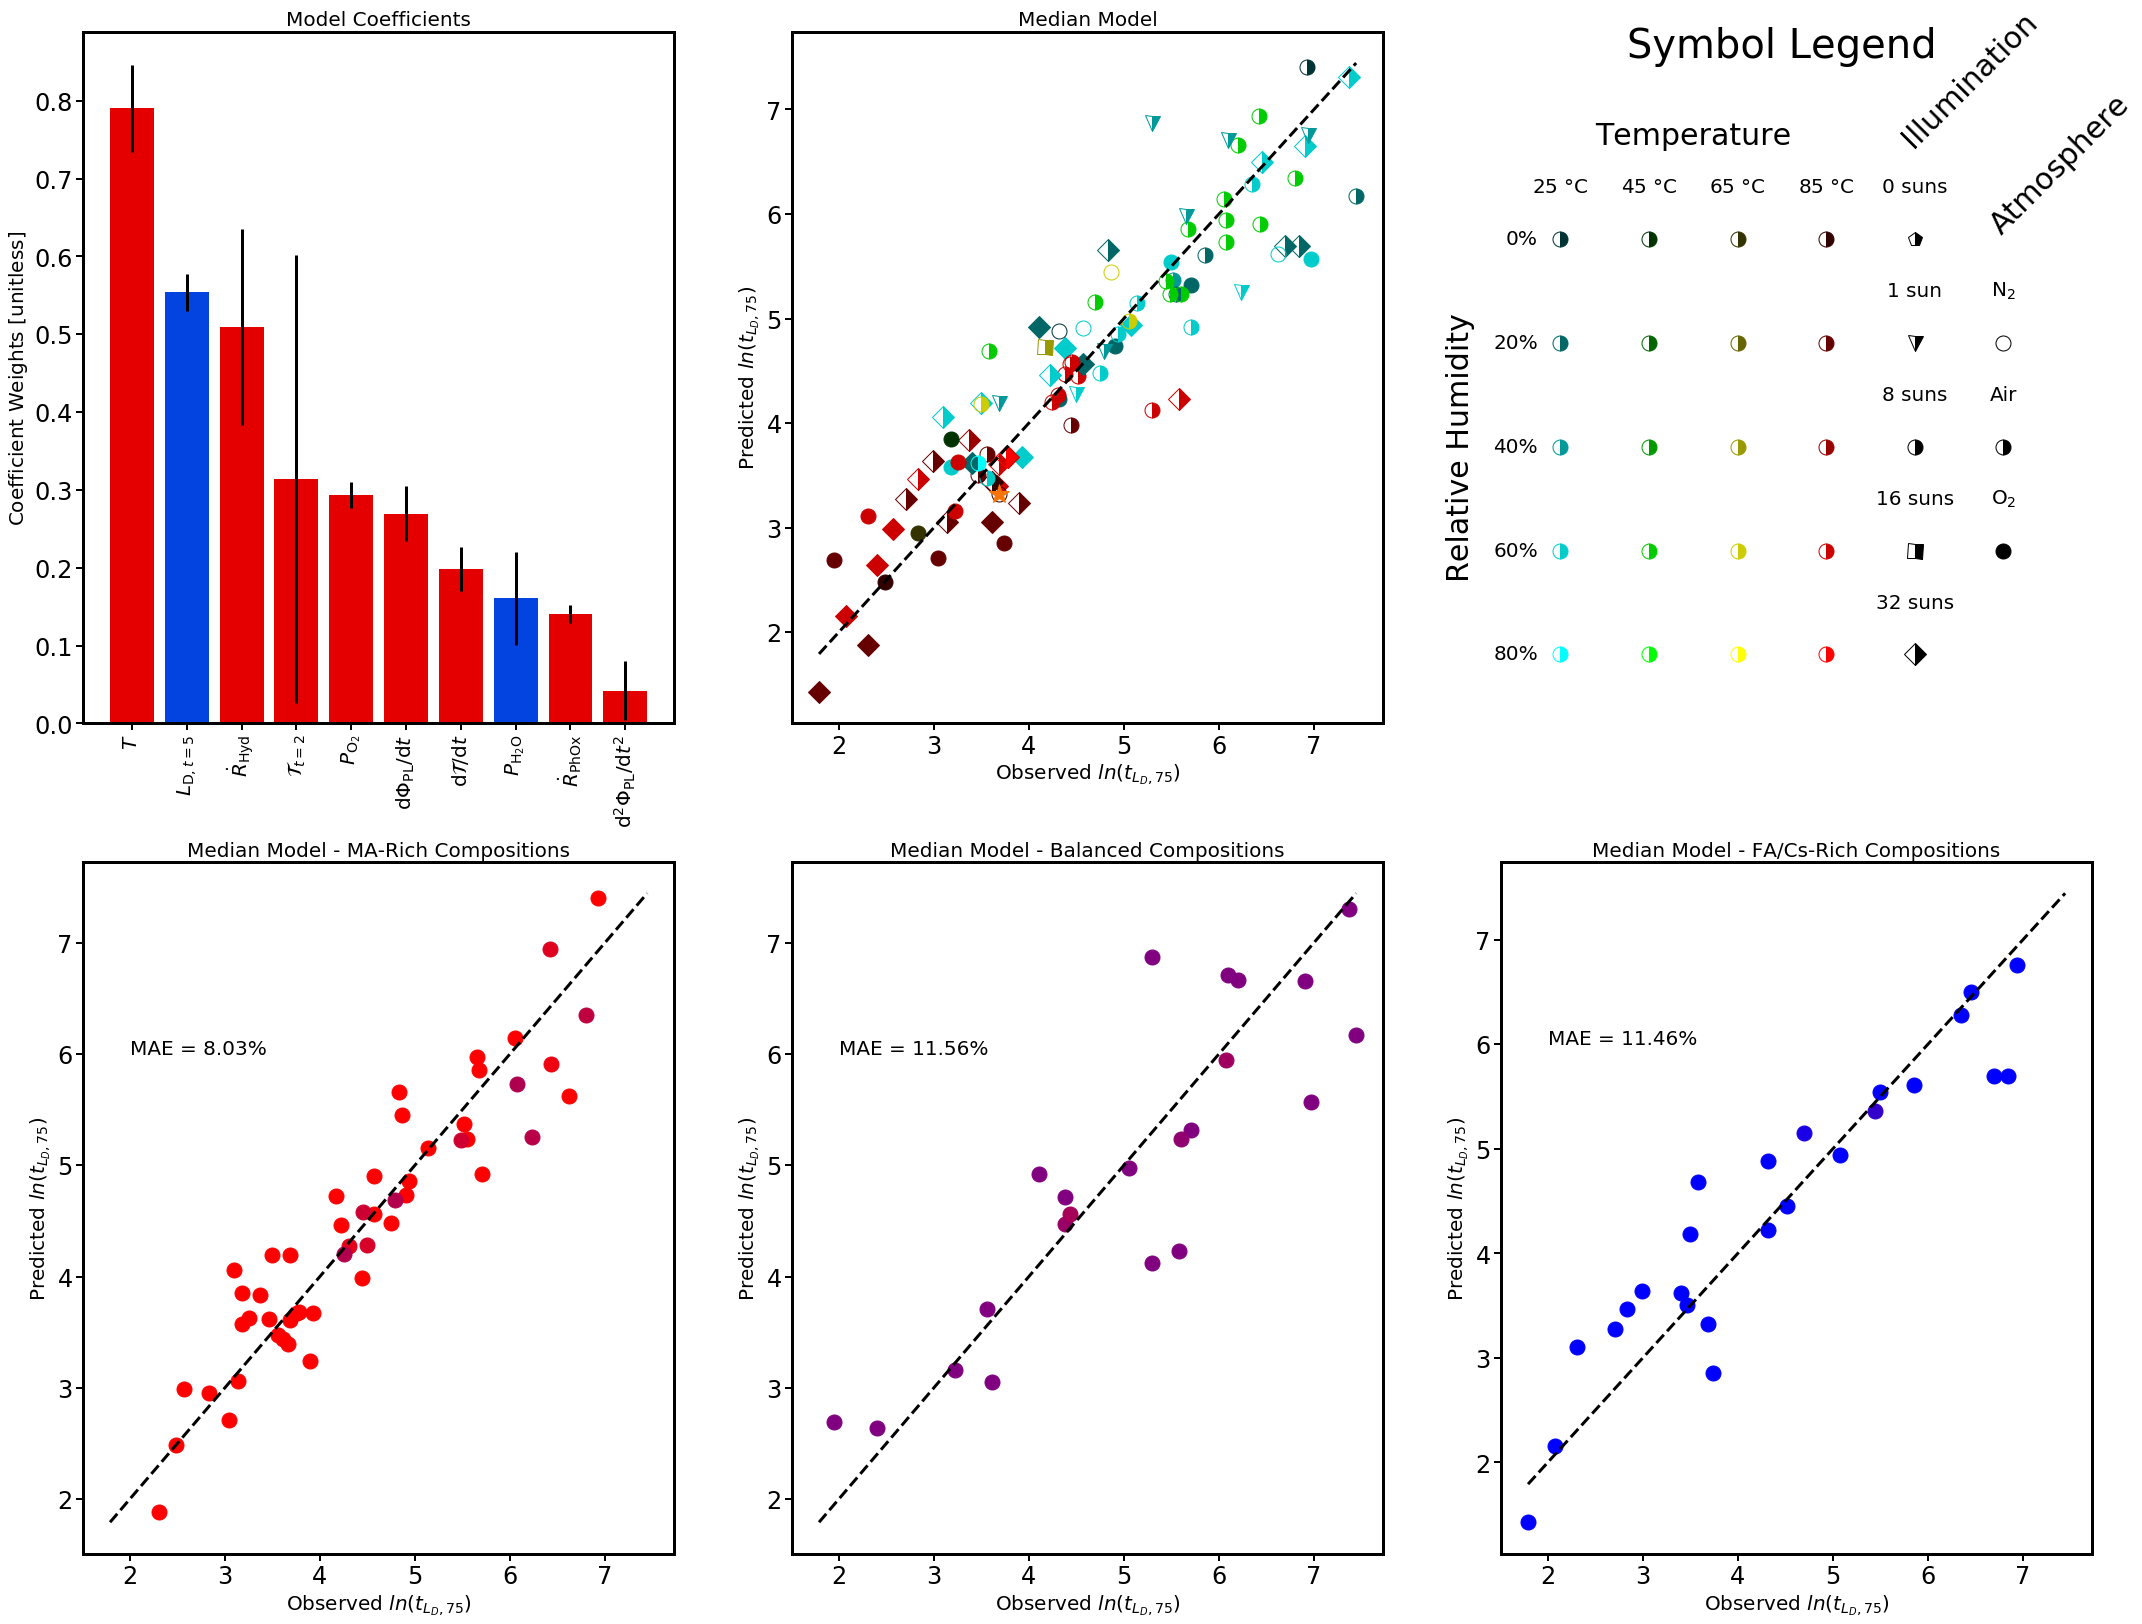

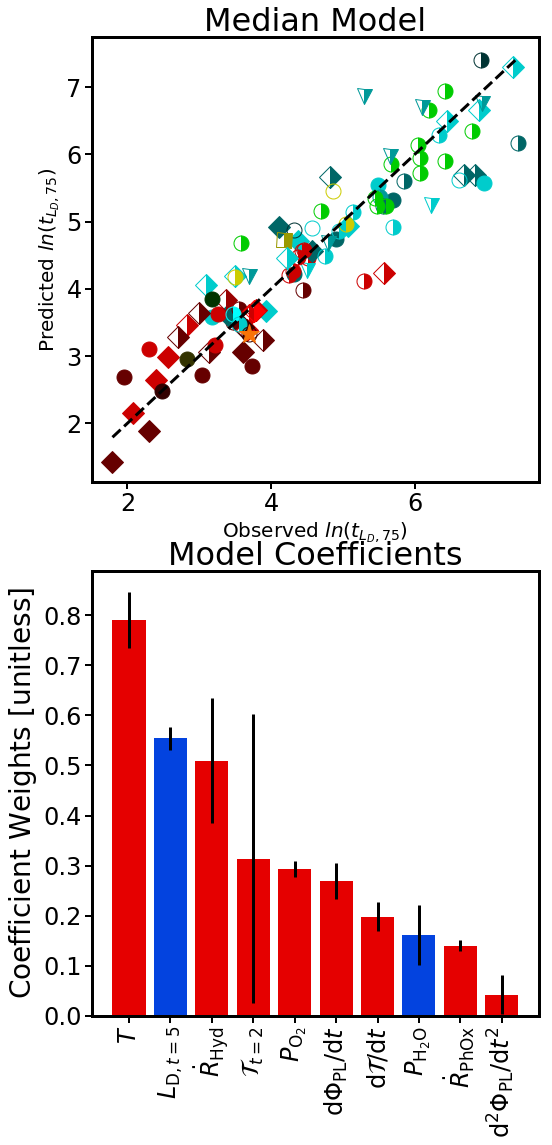

In [201]:
# PLOT FIGURE 3: Modeling Results using only ACSEL Features Set
# Updated symbol legend for more conditions

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(36,28))

##### FIRST PANEL: coefficients

# make a dataframe of coefficients and their labels etc
bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

#ax[0,0].bar(bars_df.index,bars_df['avgs'],yerr=bars_df['error'],color=bars_df['colors'])
#ax[0,0].set_xticklabels(labels=bars_df['coeffs'],rotation=90)

#ax[0,0].bar(nz_bars_df['coeffs'],nz_bars_df['avgs'],yerr=nz_bars_df['error'],color=nz_bars_df['colors'])
#ax[0,0].set_xticklabels(labels=nz_bars_df['coeffs'],rotation=90)
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_\mathrm{PL}_{t=1}$',
                     'PL2':'$\Phi_\mathrm{PL}_{t=2}$',
                     'PL3':'$\Phi_\mathrm{PL}_{t=3}$',
                     'PL4':'$\Phi_\mathrm{PL}_{t=4}$',
                     'PL5':'$\Phi_\mathrm{PL}_{t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\dot{R}_\mathrm{Hyd}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S_{mix}$' 
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax[0,0].bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[0,0].set_xticklabels(labels=fancy_labels,rotation=90,fontsize=20)

ax[0,0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=20)
ax[0,0].set_title('Model Coefficients',fontsize=20)

##### SECOND PANEL: parity plot of the median model

actual_all = []
preds_all = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    ax[0,1].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0,1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#ax[0,1].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#ax[0,1].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')


if response == 'tLD75 (min)':
    ax[0,1].set_xlabel('$\mathrm{Observed}\ ln(t_{L_D,75}$)',fontsize=20)
    ax[0,1].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)',fontsize=20)
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0,1].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$',fontsize=20)
    ax[0,1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$',fontsize=20)

ax[0,1].set_title('Median Model',fontsize=20)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    ax[0,1].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    ax[0,1].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')


actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# for LD modeling - where to put error metrics
text_x = 2
text_y = 6

# for transmittance modeling - where to put error metrics
#text_x = -9
#text_y = -4

if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    
#ax[0,1].text(text_x,text_y,'Overall $R^2 = $' + str(round(R2_overall,4)) + '\n' +\
#                 'Overall MAE = ' + str(round(np.mean(MAE_pct_overall),2)) + '%')    

##### THIRD PANEL: Symbol Legend
ax[0,2].axis('off')
ax[0,2].set_xlim([0,10])
ax[0,2].set_ylim([0,10])

origin = (1,7)
pitch = 1.5

# plot temperature/humidity symbols
pct_O2 = 21
N_suns_stress = 8
for ii in range(4):
    for jj in range(5):
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[0,2].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0,2].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=30,ha='center',va='center')

ax[0,2].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[0,2].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[0,2].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=30,ha='center',va='center',rotation=90)

# plot illumination symbols
T = 25
RH = 60


ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0,2].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=30,va='bottom')
ax[0,2].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0,2].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0,2].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=30,va='bottom')
ax[0,2].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[0,2].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

ax[0,2].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=40,ha='center')

##### FOURTH PANEL: Parity plot for MA-rich compositions

MA_rich_act = []
MA_rich_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.66:
        MA_rich_act.append(y_train.loc[idx])
        MA_rich_pred.append(ytpred[ii])
        ax[1,0].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1,0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')


if response == 'tLD75 (min)':
    ax[1,0].set_xlabel('$\mathrm{Observed}\ ln(t_{L_D,75}$)',fontsize=20)
    ax[1,0].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)',fontsize=20)
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1,0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$',fontsize=20)
    ax[1,0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$',fontsize=20)


ax[1,0].set_title('Median Model - MA-Rich Compositions',fontsize=20)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.66:
        MA_rich_act.append(y_whold.loc[idx])
        MA_rich_pred.append(ypred[ii])
        ax[1,0].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_rich_act = np.array(MA_rich_act) 
MA_rich_pred = np.array(MA_rich_pred) 
        
        
MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100

ax[1,0].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_rich_MAE_pct),2)) + '%',fontsize=20)

##### FIFTH PANEL: Parity plot for balanced compositions

MA_bal_act = []
MA_bal_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.66 and MA_frac > 0.33:
        MA_bal_act.append(y_train.loc[idx])
        MA_bal_pred.append(ytpred[ii])
        ax[1,1].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1,1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

if response == 'tLD75 (min)':
    ax[1,1].set_xlabel('$\mathrm{Observed}\ ln(t_{L_D,75}$)',fontsize=20)
    ax[1,1].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)',fontsize=20)
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1,1].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$',fontsize=20)
    ax[1,1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$',fontsize=20)

ax[1,1].set_title('Median Model - Balanced Compositions',fontsize=20)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.66 and MA_frac > 0.33:
        MA_bal_act.append(y_whold.loc[idx])
        MA_bal_pred.append(ypred[ii])
        ax[1,1].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_bal_act = np.array(MA_bal_act) 
MA_bal_pred = np.array(MA_bal_pred) 
        
        
MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
ax[1,1].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_bal_MAE_pct),2)) + '%',fontsize=20)


##### SIXTH PANEL: Parity plot for FACS-rich compositions
MA_lean_act = []
MA_lean_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_train.loc[idx])
        MA_lean_pred.append(ytpred[ii])
        ax[1,2].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1,2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

if response == 'tLD75 (min)':
    ax[1,2].set_xlabel('$\mathrm{Observed}\ ln(t_{L_D,75}$)',fontsize=20)
    ax[1,2].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)',fontsize=20)
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1,2].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$',fontsize=20)
    ax[1,2].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$',fontsize=20)

ax[1,2].set_title('Median Model - FA/Cs-Rich Compositions',fontsize=20)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_whold.loc[idx])
        MA_lean_pred.append(ypred[ii])
        ax[1,2].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_lean_act = np.array(MA_lean_act) 
MA_lean_pred = np.array(MA_lean_pred) 
        
        
MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
ax[1,2].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_lean_MAE_pct),2)) + '%',fontsize=20)


# Simple Plot of coefficients and parity 
fig2, ax2 = plt.subplots(nrows=2,ncols=1,figsize=(8,18))

actual_all = []
preds_all = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    ax2[0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax2[0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax2[0].set_xlabel('$\mathrm{Observed}\ ln(t_{L_D,75}$)')
ax2[0].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)')

if response == 'tLD75 (min)':
    ax2[0].set_xlabel('$\mathrm{Observed}\ ln(t_{L_D,75}$)',fontsize=20)
    ax2[0].set_ylabel('$\mathrm{Predicted}\ ln(t_{L_D,75}$)',fontsize=20)
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax2[0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$',fontsize=20)
    ax2[0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$',fontsize=20)

ax2[0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    ax2[0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    ax2[0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')


#actual_all = np.array(actual_all)
#preds_all = np.array(preds_all)
#R2_overall = r2_score(actual_all,preds_all)
#MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
    
#ax2[0].text(2,6,'Overall $R^2 = $' + str(round(R2_overall,4)) + '\n' +\
#                 'Overall MAE = ' + str(round(np.mean(MAE_pct_overall),2)) + '%')  

ax2[1].bar(fancy_labels,sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax2[1].set_xticklabels(fancy_labels,rotation=90)

ax2[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax2[1].set_title('Model Coefficients')

Text(2, 6, 'MAE = 12.0%')

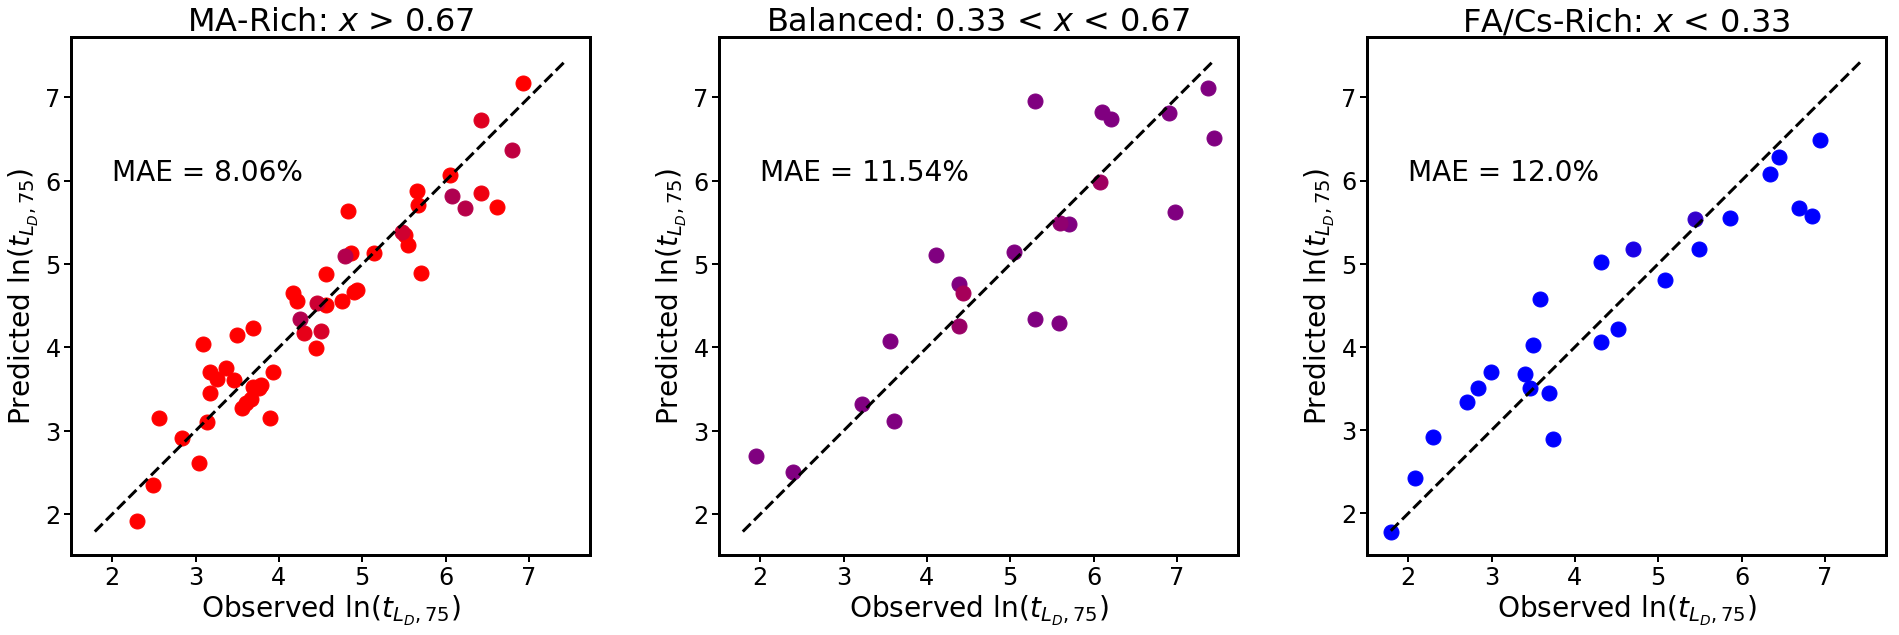

In [248]:
# Make fancy plots of composition

#fig,ax = plt.subplots(1,3,figsize=(27,9))
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge
ax0 = fig.add_axes([0 + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax1 = fig.add_axes([aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax2 = fig.add_axes([2*aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax = [ax0,ax1,ax2]



##### FOURTH PANEL: Parity plot for MA-rich compositions

MA_rich_act = []
MA_rich_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_train.loc[idx])
        MA_rich_pred.append(ytpred[ii])
        ax[0].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')


if response == 'tLD75 (min)':
    ax[0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')


ax[0].set_title('MA-Rich: $x$ > 0.67')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_whold.loc[idx])
        MA_rich_pred.append(ypred[ii])
        ax[0].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_rich_act = np.array(MA_rich_act) 
MA_rich_pred = np.array(MA_rich_pred) 
        
        
MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100

ax[0].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_rich_MAE_pct),2)) + '%')

##### FIFTH PANEL: Parity plot for balanced compositions

MA_bal_act = []
MA_bal_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_train.loc[idx])
        MA_bal_pred.append(ytpred[ii])
        ax[1].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

if response == 'tLD75 (min)':
    ax[1].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[1].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax[1].set_title('Balanced: 0.33 < $x$ < 0.67')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_whold.loc[idx])
        MA_bal_pred.append(ypred[ii])
        ax[1].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_bal_act = np.array(MA_bal_act) 
MA_bal_pred = np.array(MA_bal_pred) 
        
        
MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
ax[1].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_bal_MAE_pct),2)) + '%')


##### SIXTH PANEL: Parity plot for FACS-rich compositions
MA_lean_act = []
MA_lean_pred = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_train.loc[idx])
        MA_lean_pred.append(ytpred[ii])
        ax[2].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

if response == 'tLD75 (min)':
    ax[2].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[2].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[2].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[2].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax[2].set_title('FA/Cs-Rich: $x$ < 0.33')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_whold.loc[idx])
        MA_lean_pred.append(ypred[ii])
        ax[2].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

MA_lean_act = np.array(MA_lean_act) 
MA_lean_pred = np.array(MA_lean_pred) 
        
        
MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
ax[2].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_lean_MAE_pct),2)) + '%')

#fig.suptitle('Early-Time Features', x=0.5, y=1, fontsize=48, weight='bold')
#fig.text(0,ax_size,'a',fontsize=36,weight='bold')
#fig.text(aspect_x,ax_size,'b',fontsize=36,weight='bold')
#fig.text(2*aspect_x,ax_size,'c',fontsize=36,weight='bold')


#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
#fig.text(0,ax_size,'d',fontsize=36,weight='bold')
#fig.text(aspect_x,ax_size,'e',fontsize=36,weight='bold')
#fig.text(2*aspect_x,ax_size,'f',fontsize=36,weight='bold')

#fig.suptitle('Linear Hydration Term - No Entropy', x=0.5, y=1, fontsize=48, weight='bold')


Text(0.5, 0.45, 'c')

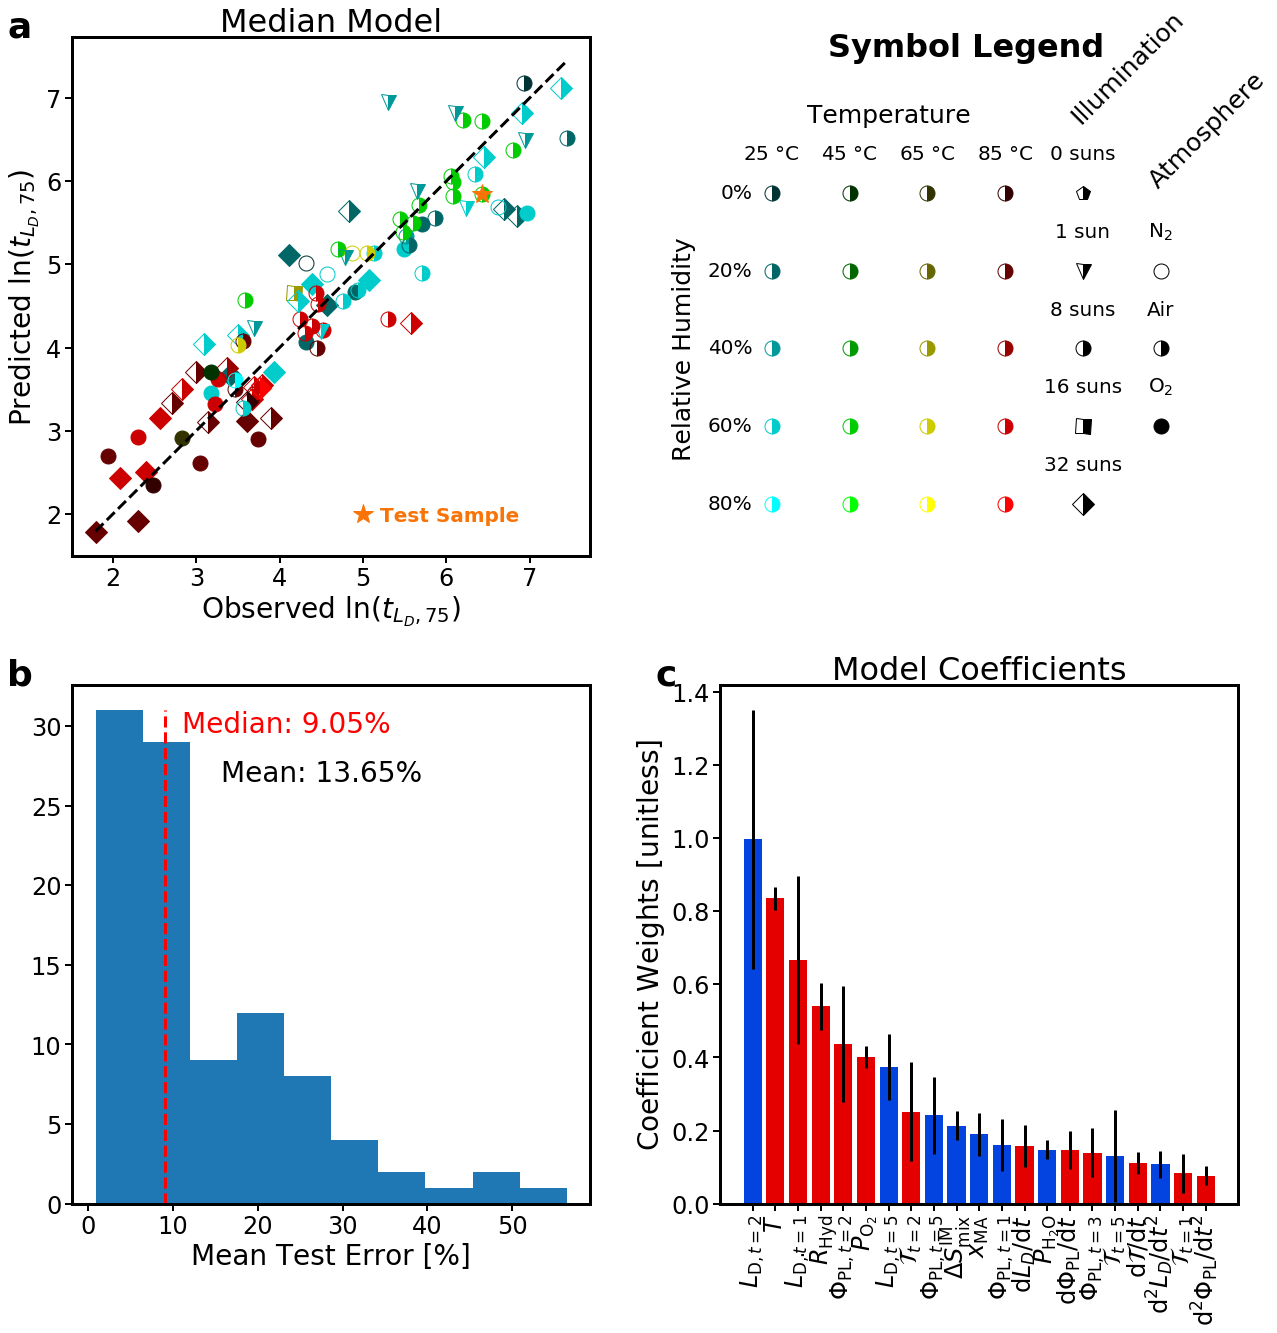

In [250]:
# Make fancy plots of test set error 

# Set up the subplots
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_x):
    row_panel_list = []
    for jj in range(n_plots_y):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list)    

# Top left: parity plot of median model
actual_all = []
preds_all = []

for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#ax[0,1].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#ax[0,1].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')


if response == 'tLD75 (min)':
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0][0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0][0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')

ax[0][0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    ax[0][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)
    ax[0][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')


# plot legend for test sample
ax[0][0].plot(5,2,marker='*',markersize=20,color='xkcd:orange')
ax[0][0].text(5.2,1.98,'Test Sample',fontsize=20,weight='bold',color='xkcd:orange',va='center')
    
actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    

if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    
# Top Right: symbol legend
ax[0][1].axis('off')
ax[0][1].set_xlim([0,10])
ax[0][1].set_ylim([0,10])

origin = (1,7)
pitch = 1.5

# plot temperature/humidity symbols
pct_O2 = 21
N_suns_stress = 8
for ii in range(4):
    for jj in range(5):
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[0][1].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0][1].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

ax[0][1].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols
T = 25
RH = 60


ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0][1].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

ax[0][1].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

ax[0][1].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')


# Bottom Left: test set error distribution
ax[1][0].hist(MAE_pct)
ax[1][0].set_xlabel('Mean Test Error [%]')
ax[1][0].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
ax[1][0].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
              'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
ax[1][0].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
              'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

# Bottom Right: coefficients

    
ax[1][1].bar(fancy_labels,sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[1][1].set_xticklabels(fancy_labels,rotation=90)

ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1][1].set_title('Model Coefficients')

#ax[1][1].fill([0.75,1.25,1.25,0.75],[1.17,1.17,1.23,1.23],color='xkcd:red')
#ax[1][1].text(1.5,1.2,'Accelerates Degradation',fontsize=24, va='center',color='xkcd:red')              
#ax[1][1].fill([0.75,1.25,1.25,0.75],[1.07,1.07,1.13,1.13],color='xkcd:blue')
#ax[1][1].text(1.5,1.1,'Decelerates Degradation',fontsize=24, va='center',color='xkcd:blue')

#ax[1][1].fill([1.5,2,2,1.5],[0.675,0.675,0.725,0.725],color='xkcd:red')
#ax[1][1].text(2.2,0.7,'Accelerates Degradation',fontsize=24, va='center',color='xkcd:red')             
#ax[1][1].fill([1.5,2,2,1.5],[0.575,0.575,0.625,0.625],color='xkcd:blue')
#ax[1][1].text(2.2,0.6,'Decelerates Degradation',fontsize=24, va='center',color='xkcd:blue')

#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
fig.text(0,0.95,'a',fontsize=36,weight='bold')
fig.text(0,0.45,'b',fontsize=36,weight='bold')
fig.text(0.5,0.45,'c',fontsize=36,weight='bold')

### Uncomment the linest below to see corners of the figure
#fig.text(0,0,'(0,0)')
#fig.text(1,0,'(1,0)')
#fig.text(0,1,'(0,1)')
#fig.text(1,1,'(1,1)')

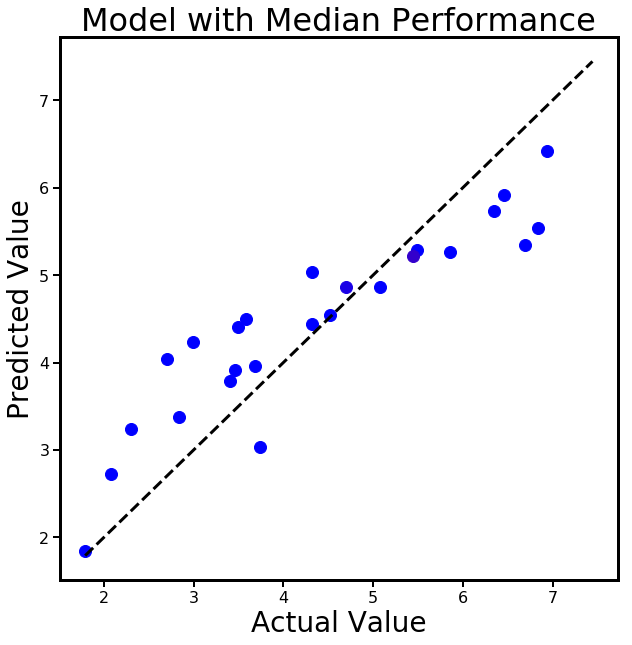

In [85]:
### COMPOSITION AS ONLY DISTINGUISHING FEATURE    

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.5:
        plt.plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    else:
        pass
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.5:
        plt.plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    else:
        pass

In [95]:
sig_bars_df

avgs   coeffs     error     colors
Ld5      0.683728      Ld5  0.151878  xkcd:blue
Temp     0.488634     Temp  0.015093   xkcd:red
dPLdt    0.427593    dPLdt  0.171711   xkcd:red
dTrdt    0.295450    dTrdt  0.043607   xkcd:red
P_O2     0.258310     P_O2  0.017318   xkcd:red
Nsuns    0.080095    Nsuns  0.033499   xkcd:red
PL5      0.078329      PL5  0.067324   xkcd:red
MA_frac  0.070961  MA_frac  0.044773   xkcd:red
Tr2      0.041796      Tr2  0.028541   xkcd:red
P_H2O    0.014576    P_H2O  0.013823   xkcd:red

{'alpha': 0.15848931924611143}
[-0.47027365 -0.02422206 -0.         -0.27567095  0.         -0.14169722
 -0.         -0.          0.         -0.          0.          0.
  0.          0.43349087 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.         -0.23483281]


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(0.5, 1.0, 'Model Coefficients')

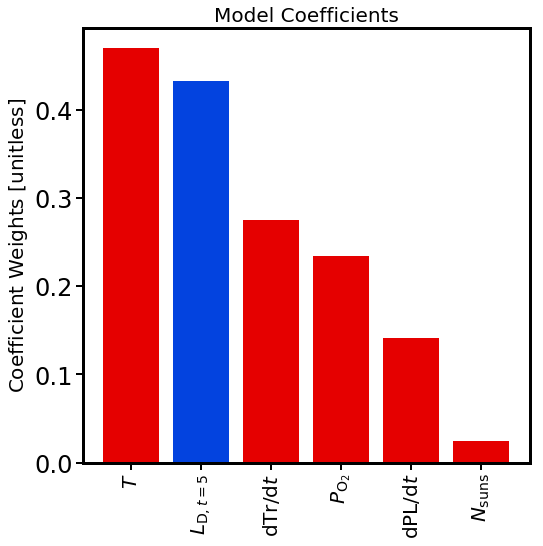

In [86]:
kk = 62
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()

# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
print(final_model.coef_)

# make predictions on the test and training data
ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
ytpred=final_model.predict(X_train)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(final_model.coef_)):
        if np.sign(final_model.coef_[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(final_model.coef_)):
        if np.sign(final_model.coef_[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')


# make a dataframe of coefficients and their labels etc
bars_df = pd.DataFrame(final_model.coef_)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = coeffs_df.columns
bars_df['avgs'] = np.abs(bars_df['avgs'])
#bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df#[nz_bars_df['avgs'] > nz_bars_df['error']]

#ax[0,0].bar(bars_df.index,bars_df['avgs'],yerr=bars_df['error'],color=bars_df['colors'])
#ax[0,0].set_xticklabels(labels=bars_df['coeffs'],rotation=90)

#ax[0,0].bar(nz_bars_df['coeffs'],nz_bars_df['avgs'],yerr=nz_bars_df['error'],color=nz_bars_df['colors'])
#ax[0,0].set_xticklabels(labels=nz_bars_df['coeffs'],rotation=90)
fancy_labels_dict = {'dTrdt':'$\mathrm{dTr}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{dPL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2Tr}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathrm{Tr}_{t=1}$',
                     'Tr2':'$\mathrm{Tr}_{t=2}$',
                     'Tr3':'$\mathrm{Tr}_{t=3}$',
                     'Tr4':'$\mathrm{Tr}_{t=4}$',
                     'Tr5':'$\mathrm{Tr}_{t=5}$',
                     'PL1':'$\mathrm{PL}_{t=1}$',
                     'PL2':'$\mathrm{PL}_{t=2}$',
                     'PL3':'$\mathrm{PL}_{t=3}$',
                     'PL4':'$\mathrm{PL}_{t=4}$',
                     'PL5':'$\mathrm{PL}_{t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\dot{R}_\mathrm{Hyd}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S_{mix}$' 
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    

fig,ax = plt.subplots(figsize=(8,8))
ax.bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],color=sig_bars_df['colors'])
ax.set_xticklabels(labels=fancy_labels,rotation=90,fontsize=20)

ax.set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=20)
ax.set_title('Model Coefficients',fontsize=20)

In [44]:
spacing/3

0.19999999999999998

In [36]:
X_train_raw = X.drop(X.index[kk]).copy()
X_train_raw.columns
np.mean(X_train_raw)

A                 5.203265e+01
D                 1.559184e+01
E                 6.169898e-01
dTrdt             1.425994e-02
dLDdt             1.435550e-04
dPLdt             1.758727e-01
ddTr0             5.475976e-04
ddPL0             5.392422e-03
ddLD0             5.467904e-04
Ld1               9.934982e-01
Ld2               9.979328e-01
Ld3               1.004541e+00
Ld4               1.010979e+00
Ld5               1.015719e+00
Tr1               1.020791e+00
Tr2               1.043652e+00
Tr3               1.068209e+00
Tr4               1.093263e+00
Tr5               1.119535e+00
PL1               1.255299e+00
PL2               1.955139e+00
PL3               3.221212e+00
PL4               4.300128e+00
PL5               5.339234e+00
P_H2O             1.421841e+03
P_O2              4.224632e+04
PhotoOx_rate      1.455113e-12
Hydration_rate    1.837170e-01
delS_mix          3.921346e-01
dtype: float64

In [37]:
np.std(X_train_raw)

A                 2.704602e+01
D                 1.187334e+01
E                 4.007058e-01
dTrdt             2.432617e-02
dLDdt             1.574612e-02
dPLdt             4.450168e-01
ddTr0             2.338820e-03
ddPL0             6.072211e-02
ddLD0             4.517260e-03
Ld1               2.746601e-02
Ld2               6.801331e-02
Ld3               9.974303e-02
Ld4               1.280249e-01
Ld5               1.574569e-01
Tr1               2.512722e-02
Tr2               5.479324e-02
Tr3               8.598188e-02
Tr4               1.173544e-01
Tr5               1.510289e-01
PL1               6.755095e-01
PL2               3.215623e+00
PL3               7.882212e+00
PL4               1.110591e+01
PL5               1.435589e+01
P_H2O             6.501940e+02
P_O2              3.672556e+04
PhotoOx_rate      2.719577e-12
Hydration_rate    3.607817e-01
delS_mix          3.659940e-01
dtype: float64

In [38]:
final_model.intercept_

4.559228897299755

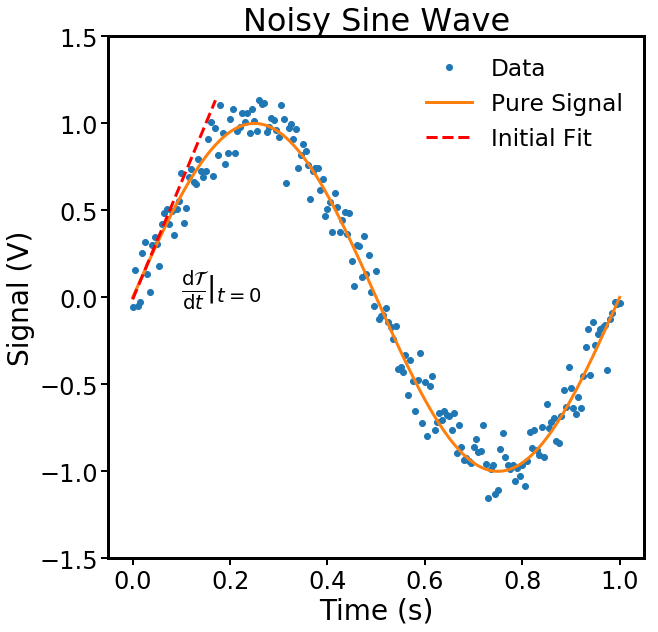

In [22]:
import random
mpl.style.use('wiley_publication.mplstyle')
x = np.linspace(0,1,num=201)
y = np.sin(2*np.pi*x)
noise = np.zeros(201)
for ii in range(len(noise)):
    noise[ii] += random.gauss(0,0.1)
fig,ax = plt.subplots()
ax.plot(x,y+noise,'.')
ax.plot(x,y)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal (V)')
ax.set_title('Noisy Sine Wave')

raw = y + noise

line = np.polyfit(x[:10],raw[:10],1)
ax.plot(x[:35],line[1]+x[:35]*line[0],'r--')

ax.set_ylim([-1.5,1.5])
ax.text(0.1,0,'$\\frac{\mathrm{d}\mathcal{T}}{\mathrm{d}t}|_{t=0}$')
ax.legend(['Data','Pure Signal','Initial Fit'],frameon=False)

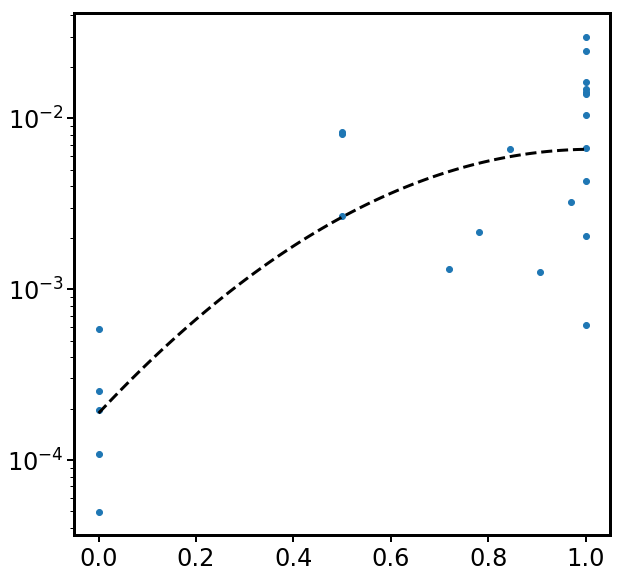

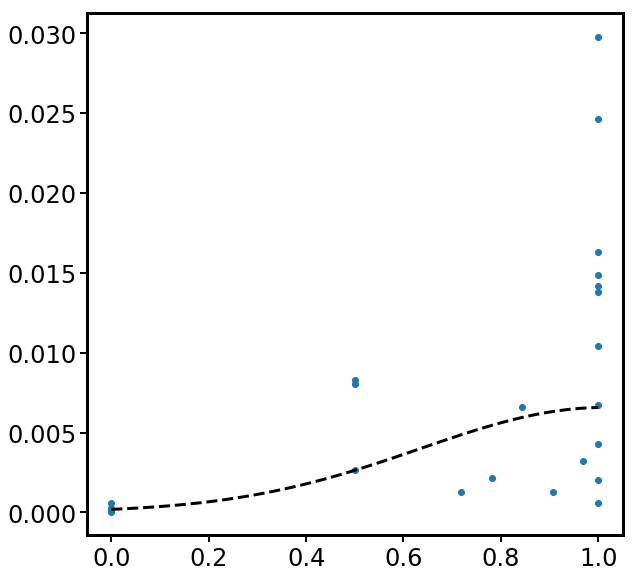

In [97]:
reduced_df = rawdata_df.copy()[rawdata_df['Temp (deg C)'] == 25]
reduced_df = reduced_df[reduced_df['RH (%)'] > 50]
reduced_df = reduced_df[reduced_df['RH (%)'] < 70]
reduced_df = reduced_df[reduced_df['Oxygen (%)'] < 100]
#reduced_df = reduced_df[reduced_df['Illum (Nsuns)'] < 16]

reduced_df
x_dat = reduced_df['MA fraction']
y_dat = reduced_df['Bleach Rate (fit to 5% inc) (1/min)']
plt.plot(x_dat,y_dat,'.')

lin_fit = np.polyfit(x,np.log(y),1)
quad_fit = np.polyfit(x,np.log(y),2)
x_fit = np.linspace(0,1,num=101)

steepness=10
inflection=0.25
limit = 0.02

steepness_grid = np.logspace(0,2,num=11)
inflection_grid = np.linspace(0,1,num=21)
limit_grid = np.linspace(0.005,0.025,num=9)

#SSE_list = []
min_SSE = 1000
for steepness in steepness_grid:
    for inflection in inflection_grid:
        for limit in limit_grid:
            sigmoid = lambda x: limit/(1+np.exp(-steepness*(x-inflection)))
            y_fit = sigmoid(x_dat)
            SSE = np.sum((y_dat-y_fit)**2)
            if SSE < min_SSE:
                min_SSE = SSE
                best_params = [steepness, inflection, limit]

[steepness, inflection, limit] = best_params
sigmoid = lambda x: limit/(1+np.exp(-steepness*(x-inflection)))


#plt.semilogy(x_fit,np.exp(lin_fit[0]*x_fit + lin_fit[1]),'k--')
#plt.plot(x_fit,sigmoid(x_fit),'k--')

plt.semilogy(x_fit,np.exp(quad_fit[0]*x_fit**2 + quad_fit[1]*x_fit + quad_fit[2]),'k--')

plt.figure()
plt.plot(x_dat,y_dat,'.')
#plt.semilogy(x_fit,sigmoid(x_fit),'k--')
plt.plot(x_fit,np.exp(quad_fit[0]*x_fit**2 + quad_fit[1]*x_fit + quad_fit[2]),'k--')

In [98]:
quad_fit

array([-3.45549193,  7.00997935, -8.57969285])

In [75]:
SSE

-0.26517156899227723

Number Passing GNG Threshold: 95
Number Exceeding GNG Threshold: 4
Fraction Passing: 0.9595959595959596
Mean MLE: 15.135215036327683
Mean + 1 stdev: 29.607146290860214
Median Index: 35
Median MLE: 10.223464762391028
Max Index: 25
Maximum MLE: 73.80626501688329
Min Index: 66
Minimum MLE: 0.022265776608094104


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.039810717055349734}


Text(0.5, 1.0, 'Model Coefficients')

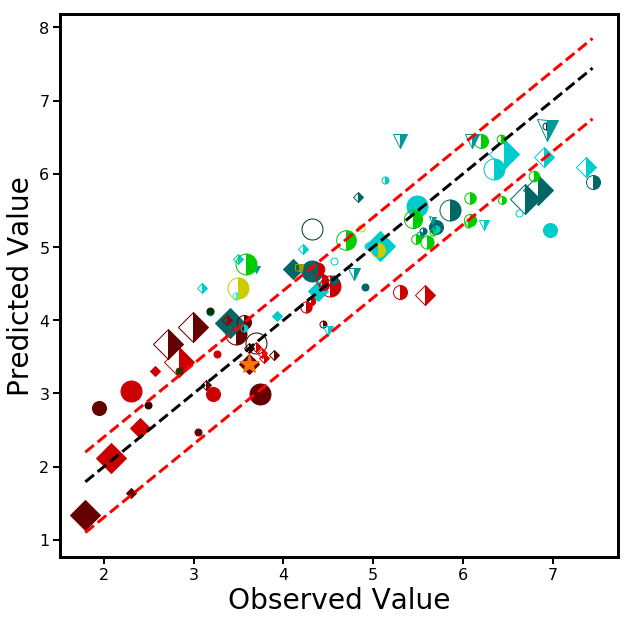

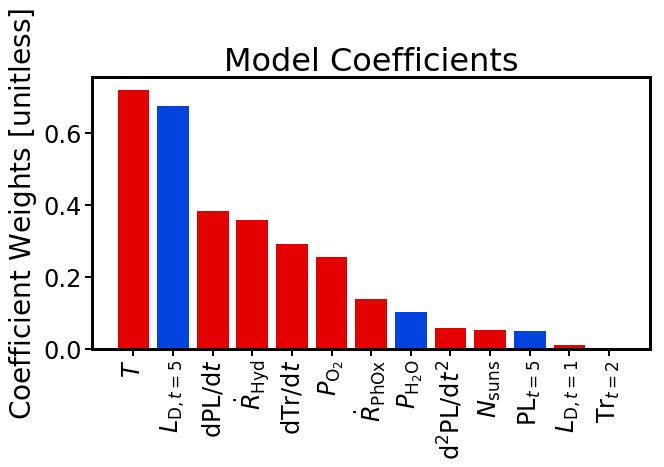

In [174]:
# sort the MLEs for each combination of test samples
MLE=MAE_pct
MLE_sorted = MAE_pct.copy()
MLE_sorted.sort()
# how many fall with the 50% error margin...
MLE_pass = [value for value in MLE if value < 50]
# and how many fall above it
MLE_fail = [value for value in MLE if value >= 50]
print('Number Passing GNG Threshold:',len(MLE_pass))
print('Number Exceeding GNG Threshold:',len(MLE_fail))
print('Fraction Passing:',len(MLE_pass)/(len(MLE_pass)+len(MLE_fail)))
print('Mean MLE:',np.mean(MLE))
print('Mean + 1 stdev:',np.mean(MLE) + np.std(MLE))

# get the median and find its index
med_MLE = np.median(MLE)
med_idx = np.argmin(np.abs(MLE-med_MLE))
print('Median Index:',med_idx)
print('Median MLE:',med_MLE)

# get the best and worst models too
max_MLE = np.max(MLE)
max_idx = np.argmax(MLE)
min_MLE = np.min(MLE)
min_idx = np.argmin(MLE)
print('Max Index:',max_idx)
print('Maximum MLE:',max_MLE)
print('Min Index:',min_idx)
print('Minimum MLE:',min_MLE)

# retrain the median model
idxs_use = list([med_idx])
#idxs_use = list(test_indices[205])
# partition the training and test sets
X_whold = X.loc[idxs_use].copy()
y_whold = Y.loc[idxs_use].copy()
X_train = X.drop(index=idxs_use).copy()
y_train = Y.drop(index=idxs_use).copy()

# standardize the data according to the mean and variance of the training dataset
z_means = []
z_stds = []

for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    #print(col_mean)
    z_means.append(col_mean)
    z_stds.append(col_std)
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
#ypred=final_model.predict(np.array(X_whold).reshape(1,-1)) # when test set is a single sample
ypred=final_model.predict(np.array(X_whold)) # when test set n > 1
ytpred=final_model.predict(X_train)

# plot training data with markers corresponding to environmental + compositional conditions

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)
    """
    for jj in range(len(coded_df[response].values)):
        if Log_transform:
            to_match = np.log(np.abs(coded_df[response].values[jj]))
        else:
            to_match = np.abs(coded_df[response].values[jj])

        if y_train[ii] == to_match:
            T = coded_df[factor_dict_inv['Temp (deg C)']].values[jj]
            RH = coded_df[factor_dict_inv['RH (%)']].values[jj]
            pct_O2 = coded_df[factor_dict_inv['Oxygen (%)']].values[jj]
            N_suns_stress = coded_df[factor_dict_inv['Illum (Nsuns)']].values[jj]
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = coded_df[factor_dict_inv['MA fraction']].values[jj]
            break
    """

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                



# save the model coefficients
coeffs_df = pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns)

# make a bar chart of the coefficients selected in the median model
fig,ax = plt.subplots(figsize=(10,5))
new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}

second_order_dict = {
    'AA':'Temp^2',
    'AB':'Temp*RH',
    'AC':'Temp*O2',
    'AD':'Temp*Nsuns',
    'AE':'Temp*MA_frac',
    'BC':'RH*O2',
    'BD':'RH*Nsuns',
    'BE':'RH*MA_frac',
    'CD':'O2*Nsuns',
    'CE':'O2*MA_frac',
    'DE':'Nsuns*MA_frac',
    'EE':'MA_frac^2'
}

coeffs_df.rename(columns = new_dict, inplace = True)
try:
    coeffs_df.rename(columns = second_order_dict, inplace = True)
except:
    pass

coeffs = coeffs_df.columns

avgs = np.mean(coeffs_df)
error = np.std(coeffs_df)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

#ax[0,0].bar(bars_df.index,bars_df['avgs'],yerr=bars_df['error'],color=bars_df['colors'])
#ax[0,0].set_xticklabels(labels=bars_df['coeffs'],rotation=90)

#ax[0,0].bar(nz_bars_df['coeffs'],nz_bars_df['avgs'],yerr=nz_bars_df['error'],color=nz_bars_df['colors'])
#ax[0,0].set_xticklabels(labels=nz_bars_df['coeffs'],rotation=90)
fancy_labels_dict = {'dTrdt':'$\mathrm{dTr}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{dPL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2Tr}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathrm{Tr}_{t=1}$',
                     'Tr2':'$\mathrm{Tr}_{t=2}$',
                     'Tr3':'$\mathrm{Tr}_{t=3}$',
                     'Tr4':'$\mathrm{Tr}_{t=4}$',
                     'Tr5':'$\mathrm{Tr}_{t=5}$',
                     'PL1':'$\mathrm{PL}_{t=1}$',
                     'PL2':'$\mathrm{PL}_{t=2}$',
                     'PL3':'$\mathrm{PL}_{t=3}$',
                     'PL4':'$\mathrm{PL}_{t=4}$',
                     'PL5':'$\mathrm{PL}_{t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\dot{R}_\mathrm{Hyd}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax.bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax.set_xticklabels(labels=fancy_labels,rotation=90)

ax.set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax.set_title('Model Coefficients')


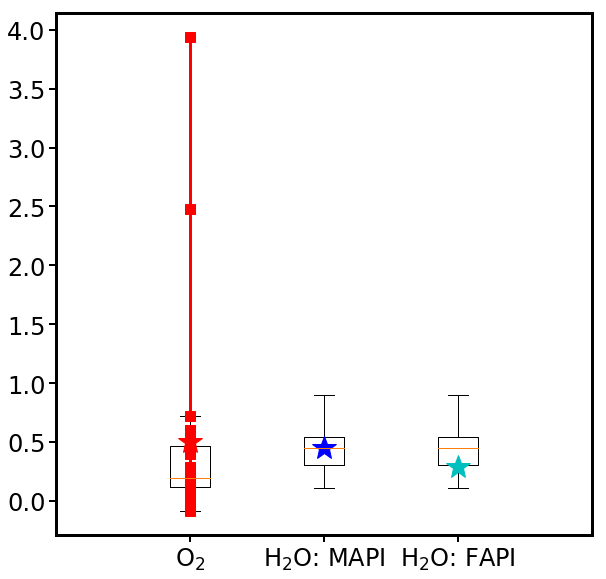

In [268]:
import random

O2_Ma = [-0.45,-0.48,-0.6,-0.54]
O2_Ouyang = [-0.14,-0.06,-0.11,-0.05,0.02,0.09]
O2_Zhou = [-0.19,-0.22,-0.24,-0.18]
O2_Brenes = [-3.94,-2.48,-0.72]
O2_Hao = [-0.398,-0.096,-0.12,-0.144,-0.15,-0.287]

O2_all = np.array(O2_Ma + O2_Ouyang + O2_Zhou + O2_Brenes + O2_Hao)

H2O_MAPI_Li = [-0.48,-0.34,-0.45,-0.45,-0.31,-0.45,-0.16,-0.11,-0.29,-0.51,-0.43,-0.5]
H2O_MAPI_Koocher = [-0.49,-0.36,-0.48,-0.4,-0.38,-0.9,-0.18,-0.13,-0.28,-0.54,-0.54,-0.54]
H2O_MAPI_Brenes = [-0.66,-0.46,-0.54]
H2O_MAPI_Hao = [-0.627,-0.627,-0.224,-0.137,-0.131,-0.333,]
H2O_MAPI_Xie = [-1.17594,-1.13924]

H2O_MAPI_all = np.array(H2O_MAPI_Li + H2O_MAPI_Koocher + H2O_MAPI_Brenes + H2O_MAPI_Hao + H2O_MAPI_Xie)

H2O_FAPI_Li = [-0.12,-0.21,-0.28,-0.32,-0.41,-0.38,-0.13,-0.41]
H2O_FAPI_Guo = [-0.26,-0.51,-0.11]

H2O_FAPI_all = np.array(H2O_FAPI_Li + H2O_FAPI_Guo)

#ax2.boxplot([MA_lean,MA_bal,MA_rich],positions=[0,0.5,1],widths=[0.05,0.05,0.05],showfliers=False)
plt.boxplot([-O2_all,-H2O_MAPI_all,-H2O_MAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])

plt.plot(0,np.mean(-O2_all),'r*',markersize=25)
plt.plot(np.zeros(len(np.array(O2_Ma))),-np.array(O2_Ma),color='r',marker='s',markersize=10)
plt.plot(np.zeros(len(np.array(O2_Ouyang))),-np.array(O2_Ouyang),color='r',marker='s',markersize=10)
plt.plot(np.zeros(len(np.array(O2_Zhou))),-np.array(O2_Zhou),color='r',marker='s',markersize=10)
plt.plot(np.zeros(len(np.array(O2_Brenes))),-np.array(O2_Brenes),color='r',marker='s',markersize=10)
plt.plot(np.zeros(len(np.array(O2_Hao))),-np.array(O2_Hao),color='r',marker='s',markersize=10)

plt.plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25)
plt.plot(1,np.mean(-H2O_FAPI_all),'c*',markersize=25)

In [299]:
np.median(O2_all)

-0.19